<a href="https://colab.research.google.com/github/naye971012/backjoon/blob/main/%EC%8B%9C%EA%B3%84%EC%97%B4_%EA%B2%B0%EC%B8%A1%EC%B9%98%EB%B3%B4%EA%B0%84_BRITS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.optim as optim
from torch.autograd import Variable
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.parameter import Parameter
import torch.nn.functional as F

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm
import ujson as json
import math

/content/drive/MyDrive/imputation_traindata


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warnin

/content/drive/MyDrive


<Figure size 1440x720 with 0 Axes>

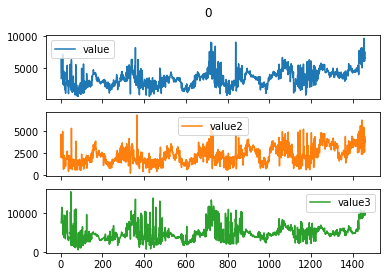

<Figure size 1440x720 with 0 Axes>

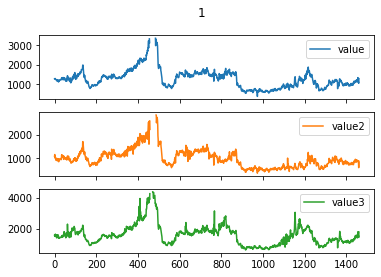

<Figure size 1440x720 with 0 Axes>

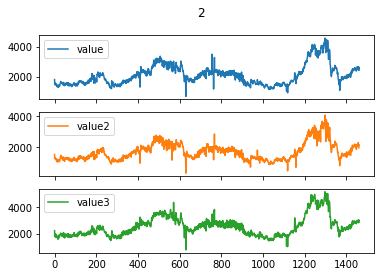

<Figure size 1440x720 with 0 Axes>

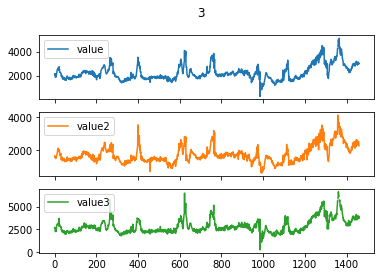

<Figure size 1440x720 with 0 Axes>

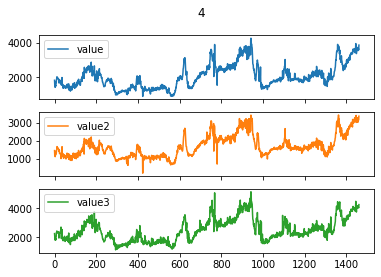

<Figure size 1440x720 with 0 Axes>

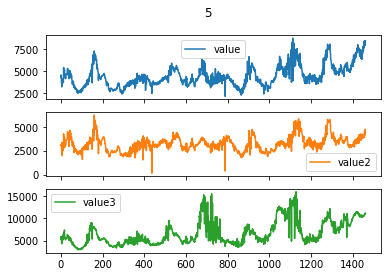

<Figure size 1440x720 with 0 Axes>

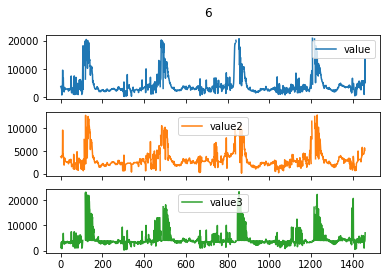

<Figure size 1440x720 with 0 Axes>

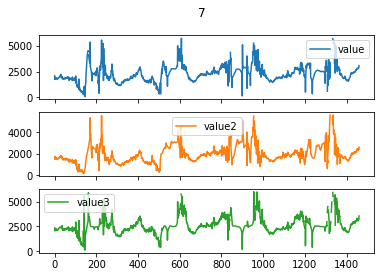

<Figure size 1440x720 with 0 Axes>

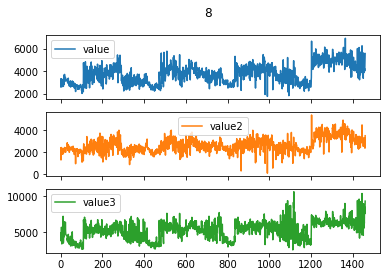

<Figure size 1440x720 with 0 Axes>

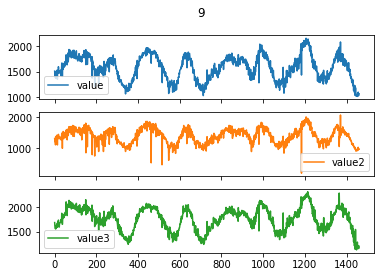

<Figure size 1440x720 with 0 Axes>

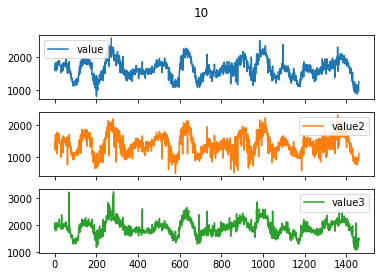

<Figure size 1440x720 with 0 Axes>

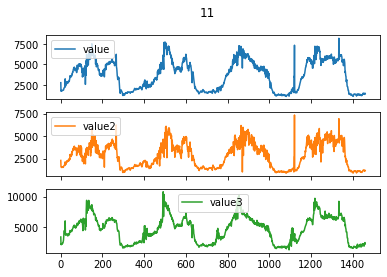

<Figure size 1440x720 with 0 Axes>

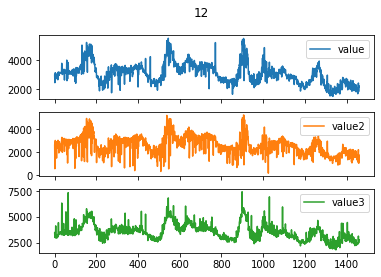

<Figure size 1440x720 with 0 Axes>

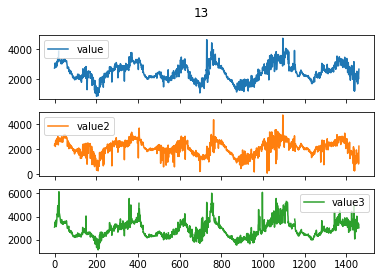

<Figure size 1440x720 with 0 Axes>

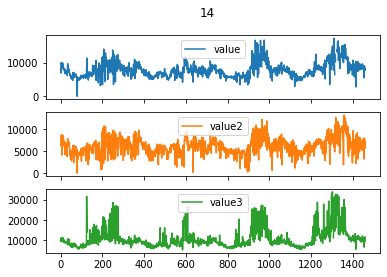

<Figure size 1440x720 with 0 Axes>

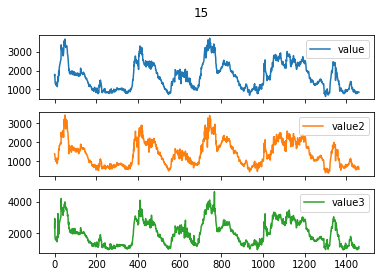

<Figure size 1440x720 with 0 Axes>

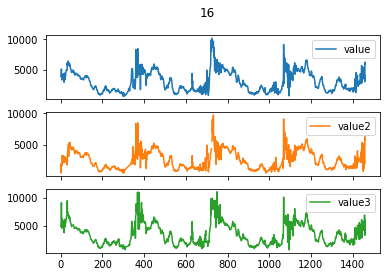

<Figure size 1440x720 with 0 Axes>

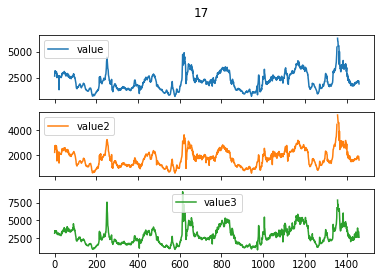

<Figure size 1440x720 with 0 Axes>

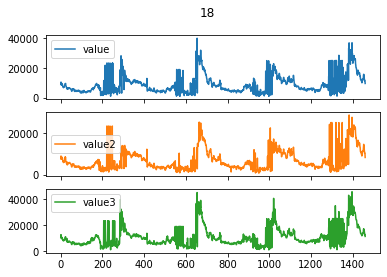

<Figure size 1440x720 with 0 Axes>

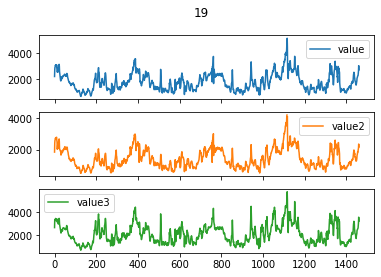

<Figure size 1440x720 with 0 Axes>

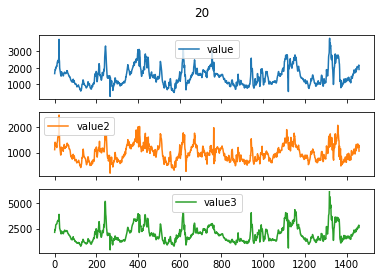

<Figure size 1440x720 with 0 Axes>

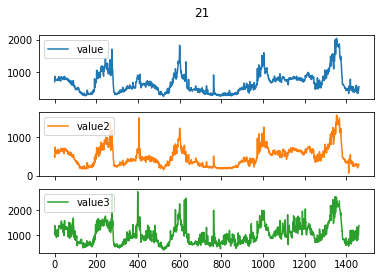

<Figure size 1440x720 with 0 Axes>

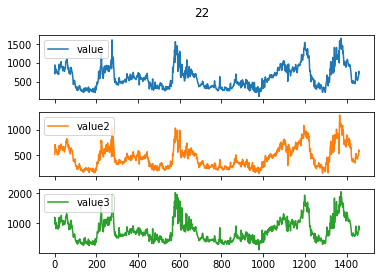

<Figure size 1440x720 with 0 Axes>

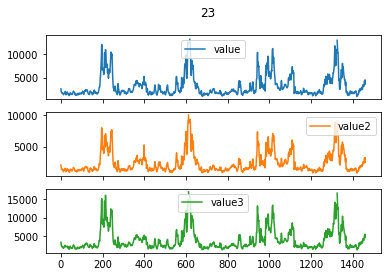

<Figure size 1440x720 with 0 Axes>

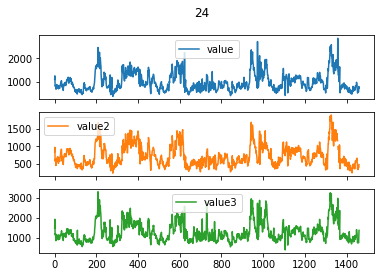

<Figure size 1440x720 with 0 Axes>

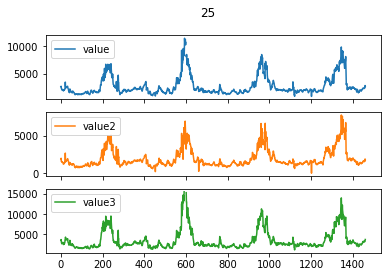

<Figure size 1440x720 with 0 Axes>

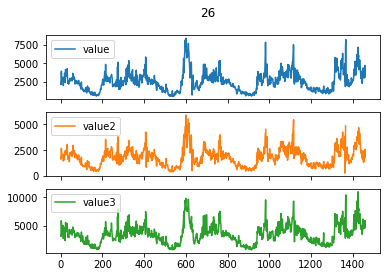

<Figure size 1440x720 with 0 Axes>

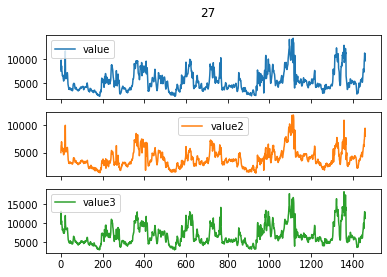

<Figure size 1440x720 with 0 Axes>

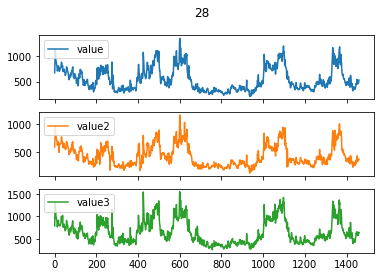

<Figure size 1440x720 with 0 Axes>

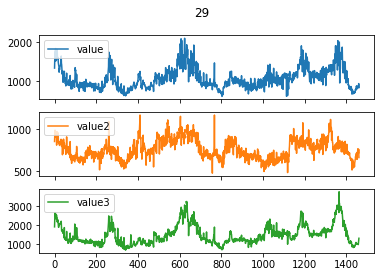

<Figure size 1440x720 with 0 Axes>

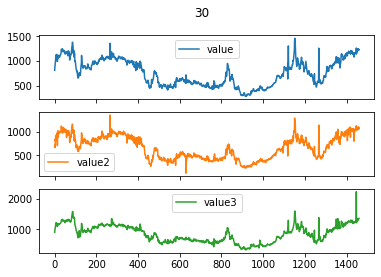

<Figure size 1440x720 with 0 Axes>

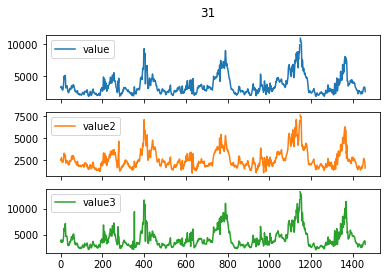

<Figure size 1440x720 with 0 Axes>

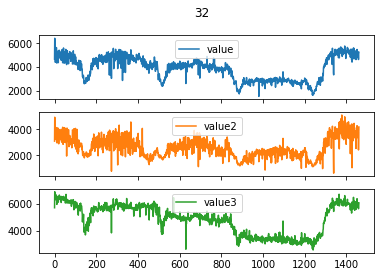

<Figure size 1440x720 with 0 Axes>

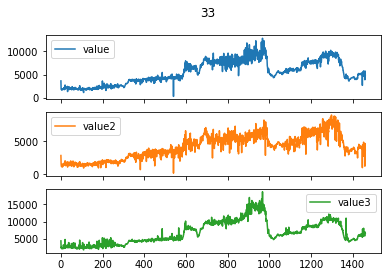

<Figure size 1440x720 with 0 Axes>

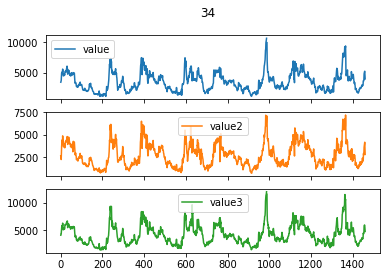

<Figure size 1440x720 with 0 Axes>

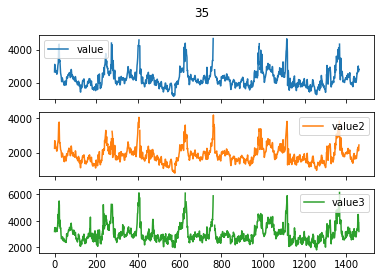

<Figure size 1440x720 with 0 Axes>

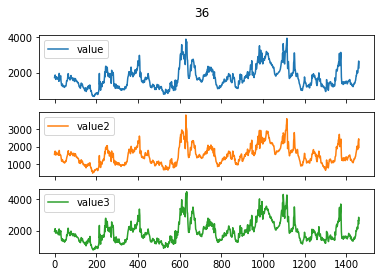

In [91]:
%cd /content/drive/MyDrive/imputation_traindata/
for j in range(37):
  data = pd.read_csv(f"train2_{j}_imputated.csv", encoding='utf-8')
  
  data["date"] = pd.to_datetime(data['datadate'].astype(str), format='%Y%m%d') #날짜변환
  data["value"] = data["해당일자_전체평균가격(원)"]

  data['value2'] = data["하위가격 평균가(원)"]
  data["value3"] = data["상위가격 평균가(원)"]
  #data['value4'] = data['일자별_도매가격_평균(원)']
  #data['value5'] = data['일자별_소매가격_평균(원)']

  #data["value"][1]=data["value"][2]
  #data["value"][366]=data["value"][367]
  #for i in range(1461):
  #  if(data['value3'][i]>20000):
  #    data['value3'][i]=np.nan
  plt.figure(figsize=(20,10))
  data[['value','value2','value3']].plot(title=f'{j}',subplots=True)
  #train_0 은 value3이 이상치가 많음
%cd /content/drive/MyDrive/

##모델 정의


In [ ]:
def parse_delta(masks, dir_):
    if dir_ == 'backward':
        masks = masks[::-1]

    deltas = []

    for h in range(len(masks)):
        if h == 0:
            deltas.append(1)
        else:
            deltas.append(1 + (1 - masks[h]) * deltas[-1])

    return np.array(deltas)

def parse_delta(masks, dir_):
    if dir_ == 'backward':
        masks = masks[::-1]

    deltas = []

    for h in range(len(masks)):
        if h == 0:
            deltas.append(1)
        else:
            deltas.append(1 + (1 - masks[h]) * deltas[-1])

    return np.array(deltas)

def parse_rec(values, masks, evals, eval_masks, dir_):
    deltas = parse_delta(masks, dir_)

    # only used in GRU-D
    forwards = pd.DataFrame(values).fillna(method='ffill').fillna(0.0).values

    rec = {}

    rec['values'] = np.nan_to_num(values).tolist()
    rec['masks'] = masks.astype('float32').tolist()
    # imputation ground-truth
    rec['evals'] = np.nan_to_num(evals).tolist()
    rec['eval_masks'] = eval_masks.astype('float32').tolist()
    rec['forwards'] = forwards.tolist()
    rec['deltas'] = deltas.tolist()
    return rec

def makedata(datapath,save):
    df = pd.read_csv(datapath)
    length = len(df)
    # df.columns = ["Time", "Velocity"]
    df = df[["time", "value"]]

    mean = df["value"].mean()
    std = df["value"].std()

    data = df
    evals = []

    for h in range(len(df)):
        evals.append(data["value"].iloc[h])
    evals = (np.array(evals) - mean) / std
    shp = evals.shape

    values = evals.copy()

    masks = ~np.isnan(values)
    eval_masks = (~np.isnan(values)) ^ (~np.isnan(evals))

    masks = masks.reshape(shp)
    eval_masks = eval_masks.reshape(shp)

    label = 0

    rec = {'label': label}
    
    # prepare the model for both directions
    rec['forward'] = parse_rec(values, masks, evals, eval_masks, dir_='forward')
    rec['backward'] = parse_rec(values[::-1], masks[::-1], evals[::-1], eval_masks[::-1], dir_='backward')

    rec = json.dumps(rec)
    fs = open(save, 'w')
    fs.write(rec)    
    fs.close()
    return length

In [ ]:
class MySet(Dataset):
    def __init__(self, file):
        super(MySet, self).__init__()
        self.content = open(file).readlines()

        indices = np.arange(len(self.content))
        val_indices = np.random.choice(indices, len(self.content) // 5)

        self.val_indices = set(val_indices.tolist())

    def __len__(self):
        return len(self.content)

    def __getitem__(self, idx):
        rec = json.loads(self.content[idx])
        if idx in self.val_indices:
            rec['is_train'] = 0
        else:
            rec['is_train'] = 1
        return rec

def collate_fn(recs):
    forward = list(map(lambda x: x['forward'], recs))
    backward = list(map(lambda x: x['backward'], recs))

    def to_tensor_dict(recs):
        values = torch.FloatTensor(list(map(lambda r: r['values'], recs))).unsqueeze(-1)
        masks = torch.FloatTensor(list(map(lambda r: r['masks'], recs))).unsqueeze(-1)
        deltas = torch.FloatTensor(list(map(lambda r: r['deltas'], recs))).unsqueeze(-1)

        evals = torch.FloatTensor(list(map(lambda r: r['evals'], recs))).unsqueeze(-1)
        eval_masks = torch.FloatTensor(list(map(lambda r: r['eval_masks'], recs))).unsqueeze(-1)
        forwards = torch.FloatTensor(list(map(lambda r: r['forwards'], recs))).unsqueeze(-1)


        return {'values': values, 'forwards': forwards, 'masks': masks, 'deltas': deltas, 'evals': evals, 'eval_masks': eval_masks}

    ret_dict = {'forward': to_tensor_dict(forward), 'backward': to_tensor_dict(backward)}

    ret_dict['labels'] = torch.FloatTensor(list(map(lambda x: x['label'], recs))).unsqueeze(-1)
    ret_dict['is_train'] = torch.FloatTensor(list(map(lambda x: x['is_train'], recs))).unsqueeze(-1)

    return ret_dict

def get_loader(file, batch_size = 64, shuffle = True):
    data_set = MySet(file)
    data_iter = DataLoader(dataset = data_set, batch_size = batch_size,num_workers = 0, shuffle = shuffle, pin_memory = True, collate_fn = collate_fn)

    return data_iter

In [ ]:
def to_var(var, device):
    if torch.is_tensor(var):
        var = Variable(var)
        var = var.to(device)
        return var
    if isinstance(var, int) or isinstance(var, float) or isinstance(var, str):
        return var
    if isinstance(var, dict):
        for key in var:
            var[key] = to_var(var[key], device)
        return var
    if isinstance(var, list):
        var = map(lambda x: to_var(x, device), var)
        return var

In [ ]:
class Brits_i(nn.Module):
    def __init__(self, rnn_hid_size, impute_weight, label_weight, seq_len, device):
        super(Brits_i, self).__init__()

        self.rnn_hid_size = rnn_hid_size
        self.impute_weight = impute_weight
        self.label_weight = label_weight
        self.seq_len = seq_len
        self.device = device

        self.build()

    def build(self):
        self.rits_f = Rits_i(self.rnn_hid_size, self.impute_weight, self.label_weight,self.seq_len, self.device)
        self.rits_b = Rits_i(self.rnn_hid_size, self.impute_weight, self.label_weight,self.seq_len, self.device)

    def forward(self, data):
        ret_f = self.rits_f(data, 'forward')
        ret_b = self.reverse(self.rits_b(data, 'backward'))

        ret = self.merge_ret(ret_f, ret_b)

        return ret

    def merge_ret(self, ret_f, ret_b):
        loss_f = ret_f['loss']
        loss_b = ret_b['loss']
        loss_c = self.get_consistency_loss(ret_f['imputations'], ret_b['imputations'])

        loss = loss_f + loss_b + loss_c

        predictions = (ret_f['predictions'] + ret_b['predictions']) / 2
        imputations = (ret_f['imputations'] + ret_b['imputations']) / 2

        ret_f['loss'] = loss
        ret_f['predictions'] = predictions
        ret_f['imputations'] = imputations

        return ret_f

    def get_consistency_loss(self, pred_f, pred_b):
        loss = torch.abs(pred_f - pred_b).mean() * 1e-1
        return loss

    def reverse(self, ret):
        def reverse_tensor(tensor_):
            if tensor_.dim() <= 1:
                return tensor_
            indices = range(tensor_.size()[1])[::-1]
            indices = Variable(torch.LongTensor(indices), requires_grad = False)

            # if torch.cuda.is_available():
            indices = indices.to(self.device)

            return tensor_.index_select(1, indices)

        for key in ret:
            ret[key] = reverse_tensor(ret[key])

        return ret

    def run_on_batch(self, data, optimizer, epoch=None):
        ret = self(data)

        if optimizer is not None:
            optimizer.zero_grad()
            ret['loss'].backward()
            optimizer.step()

        return ret

def binary_cross_entropy_with_logits(input, target, weight=None, size_average=True, reduce=True):
    if not (target.size() == input.size()):
        raise ValueError("Target size ({}) must be the same as input size ({})".format(target.size(), input.size()))

    max_val = (-input).clamp(min=0)
    loss = input - input * target + max_val + ((-max_val).exp() + (-input - max_val).exp()).log()

    if weight is not None:
        loss = loss * weight

    if not reduce:
        return loss
    elif size_average:
        return loss.mean()
    else:
        return loss.sum()


class TemporalDecay(nn.Module):
    def __init__(self, input_size, rnn_hid_size):
        super(TemporalDecay, self).__init__()
        self.rnn_hid_size = rnn_hid_size
        self.build(input_size)

    def build(self, input_size):
        self.W = Parameter(torch.Tensor(self.rnn_hid_size, input_size))
        self.b = Parameter(torch.Tensor(self.rnn_hid_size))
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.W.size(0))
        self.W.data.uniform_(-stdv, stdv)
        if self.b is not None:
            self.b.data.uniform_(-stdv, stdv)

    def forward(self, d):
        gamma = F.relu(F.linear(d, self.W, self.b))
        gamma = torch.exp(-gamma)
        return gamma

class Rits_i(nn.Module):
    def __init__(self, rnn_hid_size, impute_weight, label_weight, seq_len, device):
        super(Rits_i, self).__init__()

        self.rnn_hid_size = rnn_hid_size
        self.impute_weight = impute_weight
        self.label_weight = label_weight
        self.seq_len = seq_len
        self.device = device

        self.build()

    def build(self):
        self.input_size = 1
        self.rnn_cell = nn.LSTMCell(self.input_size * 2, self.rnn_hid_size)

        self.regression = nn.Linear(self.rnn_hid_size, self.input_size)
        self.temp_decay = TemporalDecay(input_size = self.input_size, rnn_hid_size = self.rnn_hid_size)

        self.out = nn.Linear(self.rnn_hid_size, 1)

    def forward(self, data, direct):
        values = data[direct]['values']
        masks = data[direct]['masks']
        deltas = data[direct]['deltas']

        evals = data[direct]['evals']
        eval_masks = data[direct]['eval_masks']

        labels = data['labels'].view(-1, 1)
        is_train = data['is_train'].view(-1, 1)

        h = Variable(torch.zeros((values.size()[0], self.rnn_hid_size)))
        c = Variable(torch.zeros((values.size()[0], self.rnn_hid_size)))

        h, c = h.to(self.device), c.to(self.device)

        x_loss = 0.0
        y_loss = 0.0

        imputations = []

        for t in range(self.seq_len):
            x = values[:, t, :]
            m = masks[:, t, :]
            d = deltas[:, t, :]
            gamma = self.temp_decay(d)
            h = h * gamma
            x_h = self.regression(h)

            x_c =  m * x +  (1 - m) * x_h

            x_loss += torch.sum(torch.abs(x - x_h) * m) / (torch.sum(m) + 1e-5)

            inputs = torch.cat([x_c, m], dim = 1)

            h, c = self.rnn_cell(inputs, (h, c))

            imputations.append(x_c.unsqueeze(dim = 1))

        imputations = torch.cat(imputations, dim = 1)

        y_h = self.out(h)
        y_loss = binary_cross_entropy_with_logits(y_h, labels, reduce = False)

        # only use training labels
        y_loss = torch.sum(y_loss * is_train) / (torch.sum(is_train) + 1e-5)

        y_h = torch.sigmoid(y_h)

        return {'loss': x_loss * self.impute_weight + y_loss * self.label_weight, 'predictions': y_h,\
                'imputations': imputations, 'labels': labels, 'is_train': is_train,\
                'evals': evals, 'eval_masks': eval_masks}

    def run_on_batch(self, data, optimizer, epoch = None):
        ret = self(data, direct = 'forward')

        if optimizer is not None:
            optimizer.zero_grad()
            ret['loss'].backward()
            optimizer.step()

        return ret

In [ ]:
def evaluate():
    model.eval()
    imputations = []
    for idx, data in enumerate(data_iter):
        data = to_var(data, device)
        ret = model.run_on_batch(data, None)
        eval_masks = ret['eval_masks'].data.cpu().numpy()
        imputation = ret['imputations'].data.cpu().numpy()
        imputations += imputation[np.where(eval_masks == 1)].tolist()
    imputations = np.asarray(imputations)
    return imputation

def predict_result():
    imputation  = evaluate()
    scaler = StandardScaler()
    scaler = scaler.fit(df["value"].to_numpy().reshape(-1,1))
    result = scaler.inverse_transform(imputation[0])
    return result[:,0]

## 모델 훈련


In [ ]:

%mkdir 'imputation_traindata'
for i in range(37):
  %cd /content/drive/MyDrive/imputation_traindata/
  df_raw = pd.read_csv(f"train_{i}_imputated.csv",encoding='utf-8')
  
  for j in range(1): #변수 늘리고싶으면 이거로
    %cd /content/drive/MyDrive/imputation_traindata/
    df2 = pd.DataFrame()
    df2["time"] =  pd.to_datetime(df_raw['datadate'].astype(str), format='%Y%m%d')
    if(j==0):
      df2["value"] = df_raw["상위가격 평균가(원)"]
    else:
      df2["value"]= df_raw["하위가격 평균가(원)"]

    df2.to_csv(f"train2_{i}.csv", index=False)
    %cd /content/drive/MyDrive/imputation_traindata/

    device = torch.device("cuda:0")
    df = pd.read_csv(f"train2_{i}.csv")
    data = df["value"]
    length = len(df)

    makedata(f"train2_{i}.csv",f"train2_{i}.json")

    #(hidden_state_dim, impute_weight, label_weight, length, device)
    #여기서는 classification 없이 imputation만 하므로, impute weight를 1, label weight를 0으로 설정한다.
    model = Brits_i(108, 1, 0, length, device).to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.01)
    data_iter = get_loader(f'train2_{i}.json', batch_size=64)

    epoch = 100
    model.train()
    progress = tqdm(range(epoch))
    for k in progress:
        tl=0.0
        for idx, data in enumerate(data_iter):  
            data = to_var(data,device)
            ret =model.run_on_batch(data,optimizer, k)
            tl += ret["loss"]
        progress.set_description("loss: {:0.6f}".format(tl/len(data_iter)))
    
    result =predict_result()
    print(result)
    """
    plt.figure(figsize=(20,5))
    plt.plot(df["value"], label="real", zorder=10)
    plt.plot(result, label="predict")
    plt.legend()
    plt.show()"""
    if(j==0):
      df_raw['상위가격 평균가(원)']=result
    else:
      df_raw['하위가격 평균가(원)']=result
  df_raw.to_csv(f"train_{i}_imputated.csv")

결측치 길이측정 -> 대부분 10 미만 ->brits이용

In [76]:
%cd /content/drive/MyDrive
new_data = pd.read_csv(f"./data/train/train_16.csv", encoding='utf-8')

new_data["value"] = new_data["해당일자_전체평균가격(원)"]
new_data['value2'] = new_data["하위가격 평균가(원)"]
new_data["value3"] = new_data["상위가격 평균가(원)"]
new_data=new_data[['value','value2','value3']]
none=[]
xx=0
new_data=new_data.fillna(0)
for i in range(1461):
  if(new_data['value3'][i]==0):
    xx+=1
  else:
    none.append(xx)
    xx=0
print(none)

/content/drive/MyDrive
[2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 7, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 2, 1, 3, 20, 6, 1, 0, 0, 2, 13, 3, 5, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

상관관계 분석 -> value 123은 거의 항상 관계
value4,5는 경우에 따라 다름

/content/drive/MyDrive/imputation_traindata


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


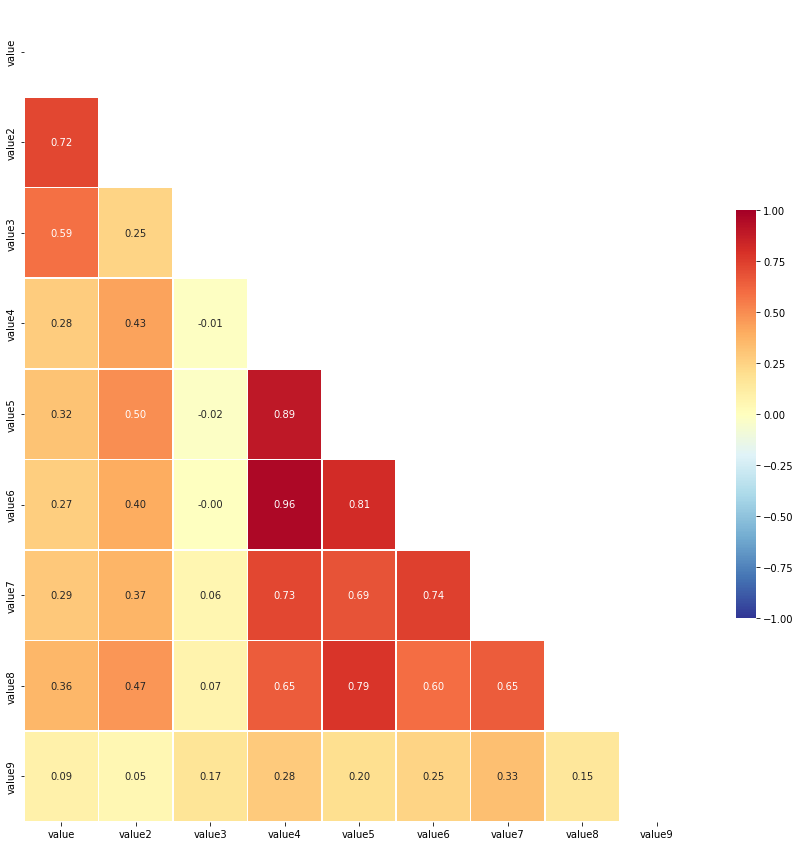

/content/drive/MyDrive/imputation_traindata


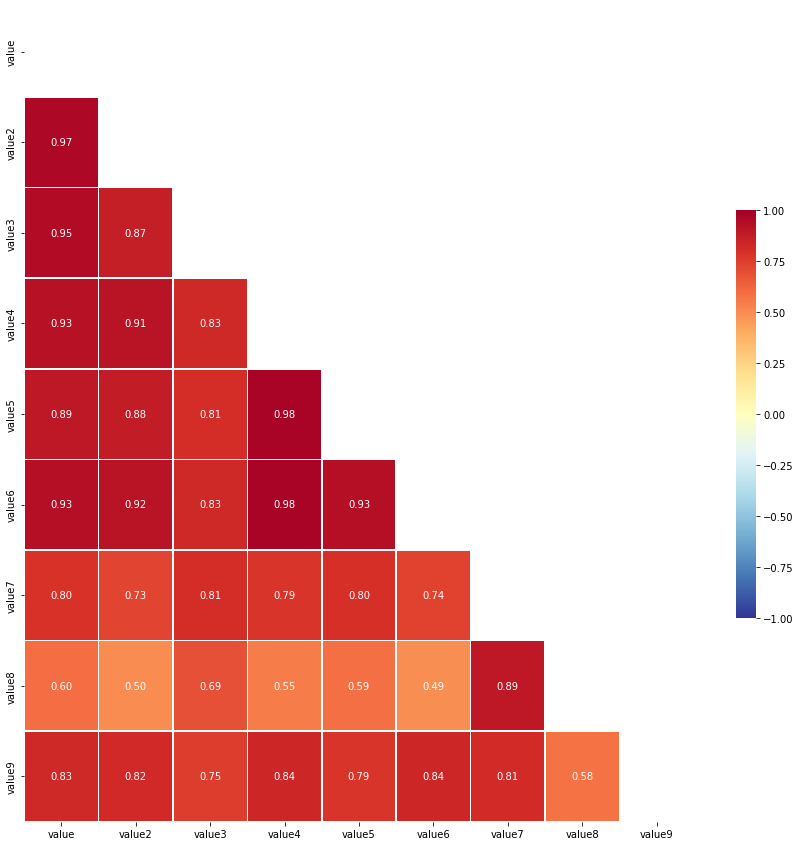

/content/drive/MyDrive/imputation_traindata


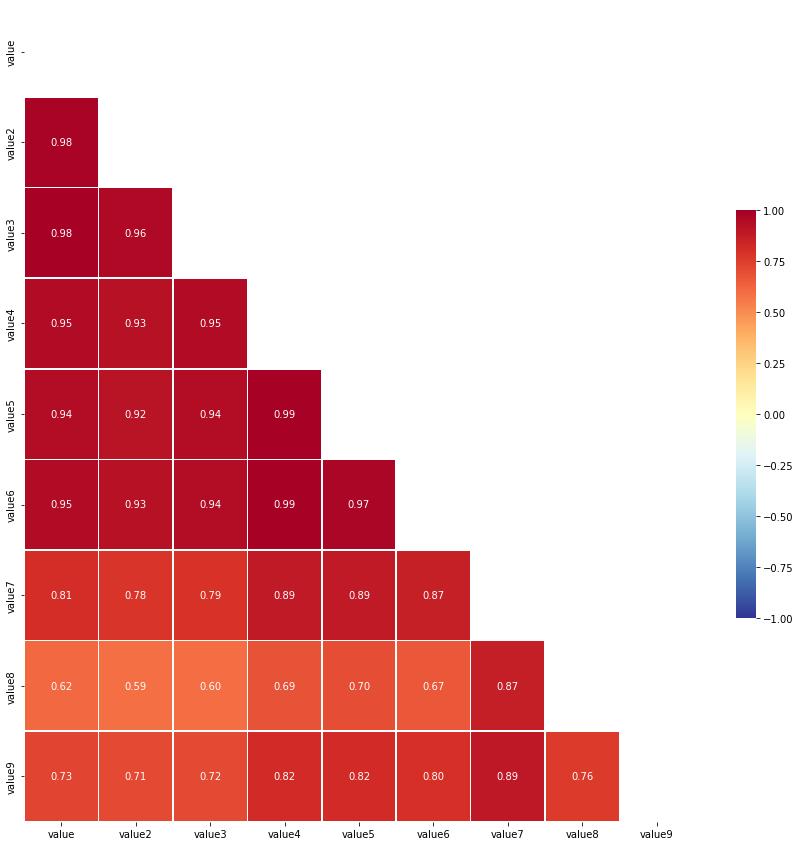

/content/drive/MyDrive/imputation_traindata


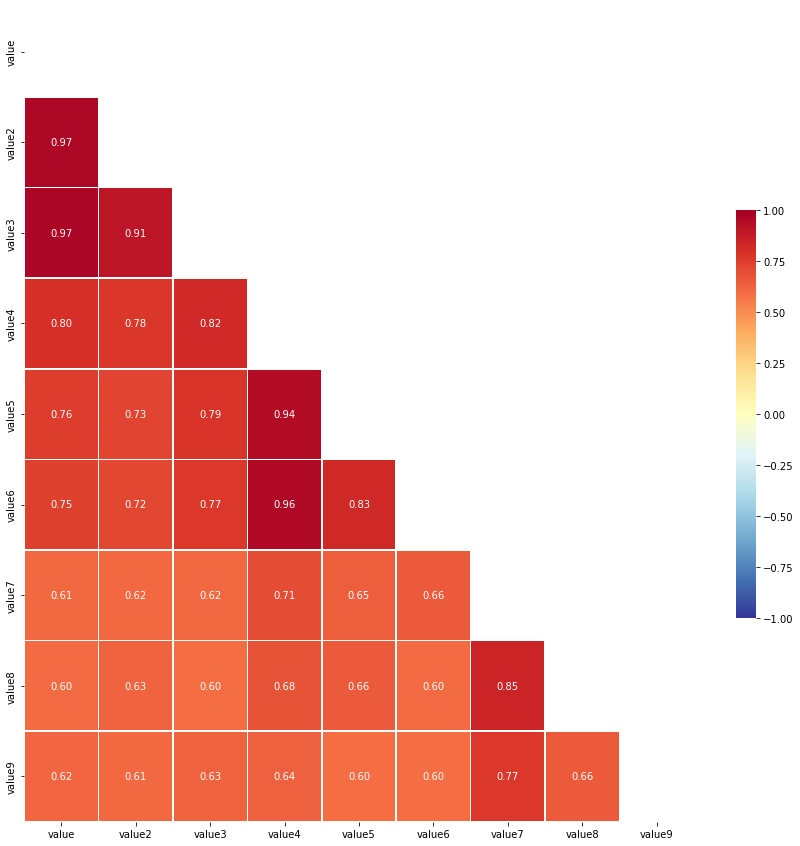

/content/drive/MyDrive/imputation_traindata


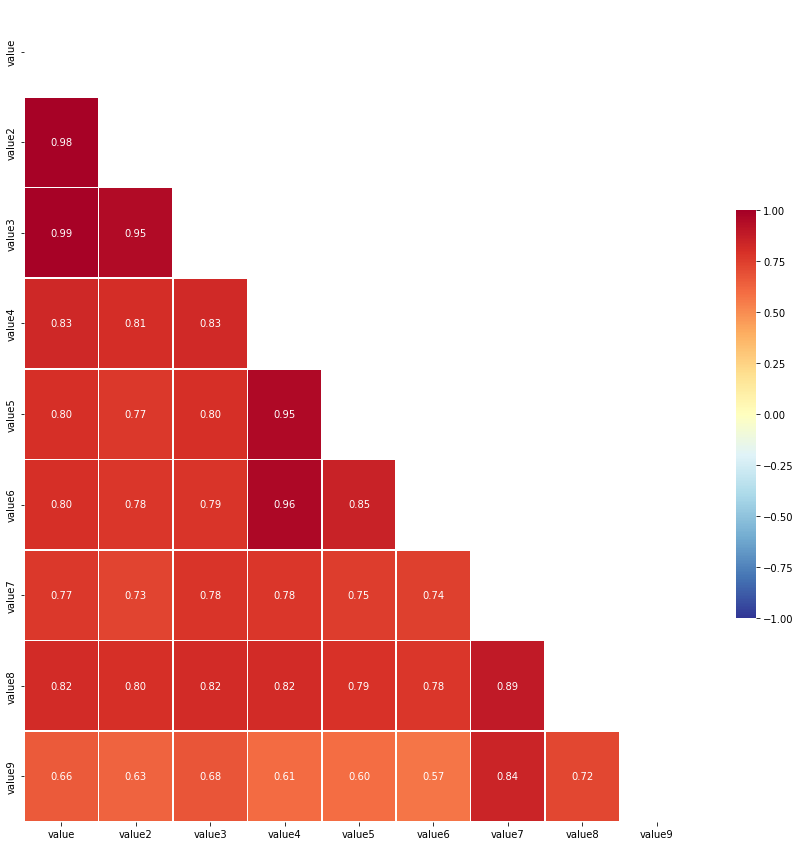

/content/drive/MyDrive/imputation_traindata


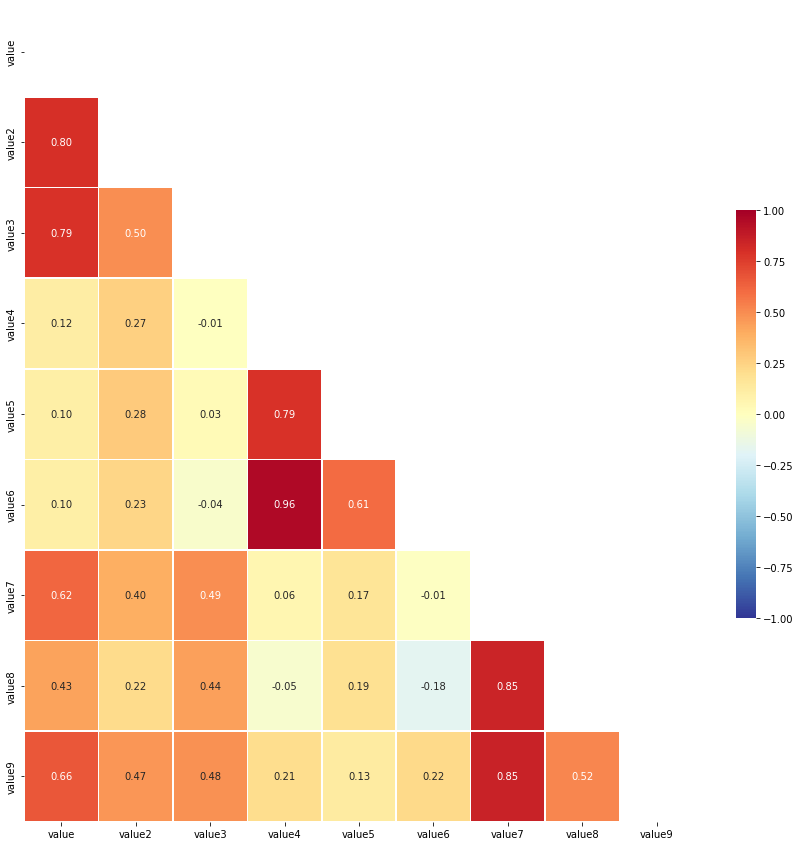

/content/drive/MyDrive/imputation_traindata


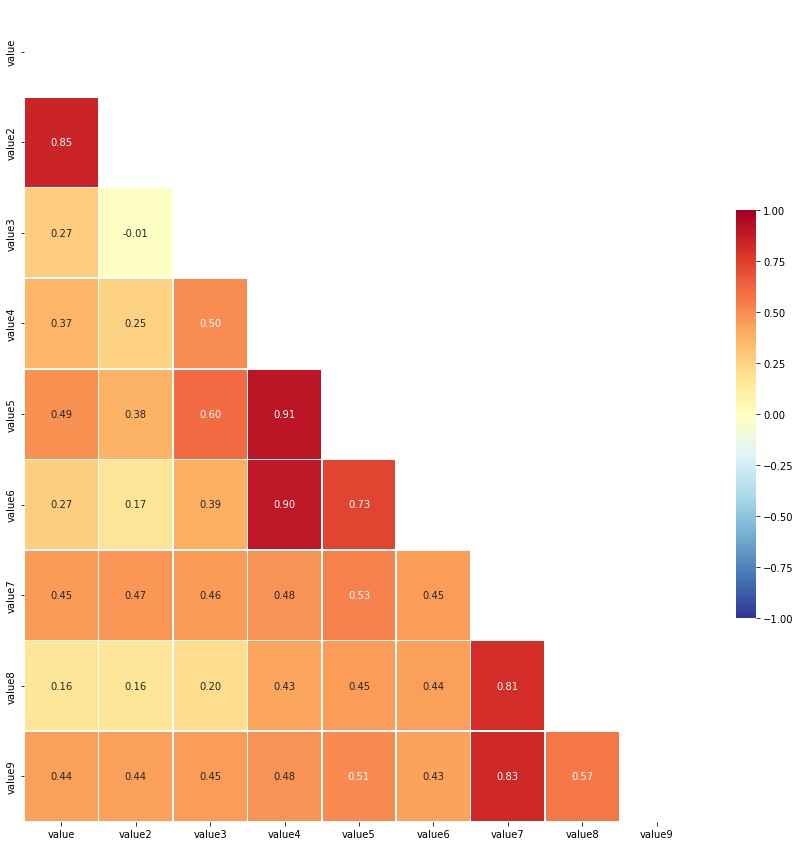

/content/drive/MyDrive/imputation_traindata


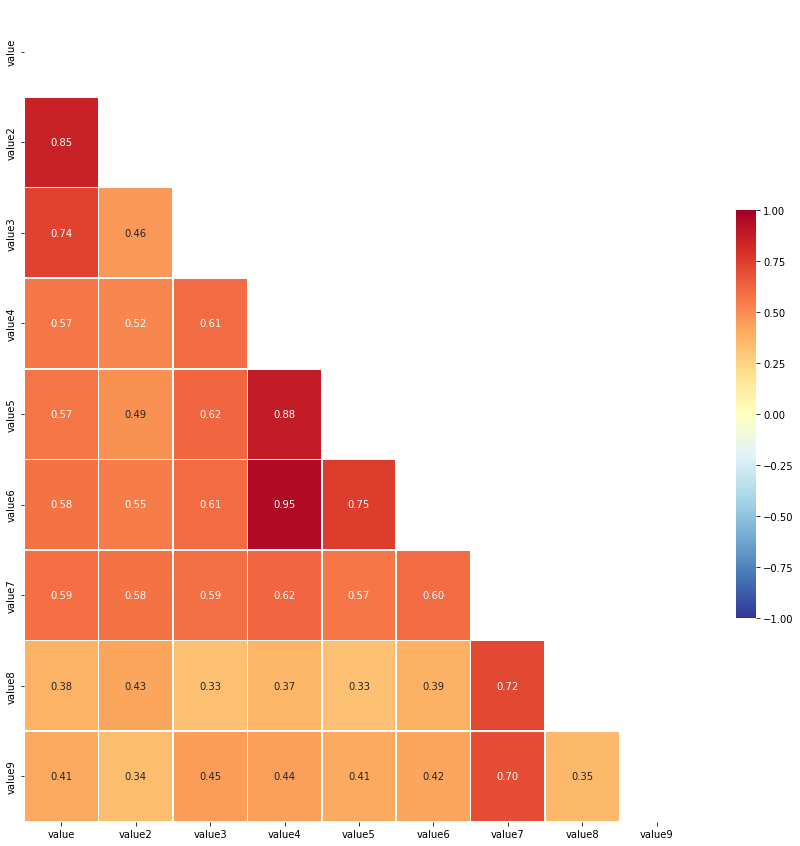

/content/drive/MyDrive/imputation_traindata


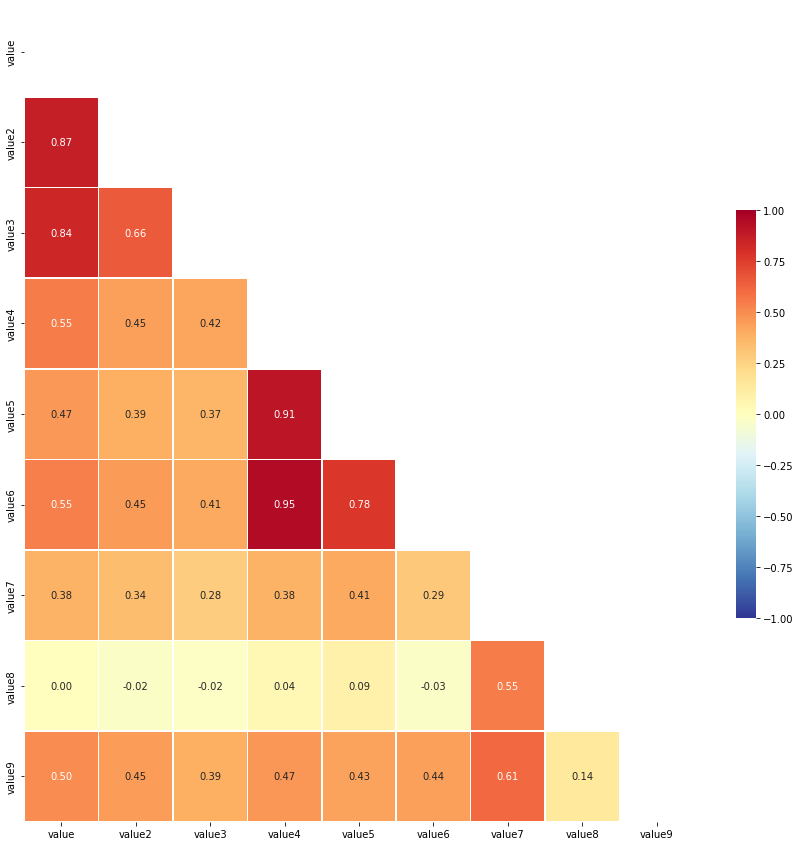

/content/drive/MyDrive/imputation_traindata


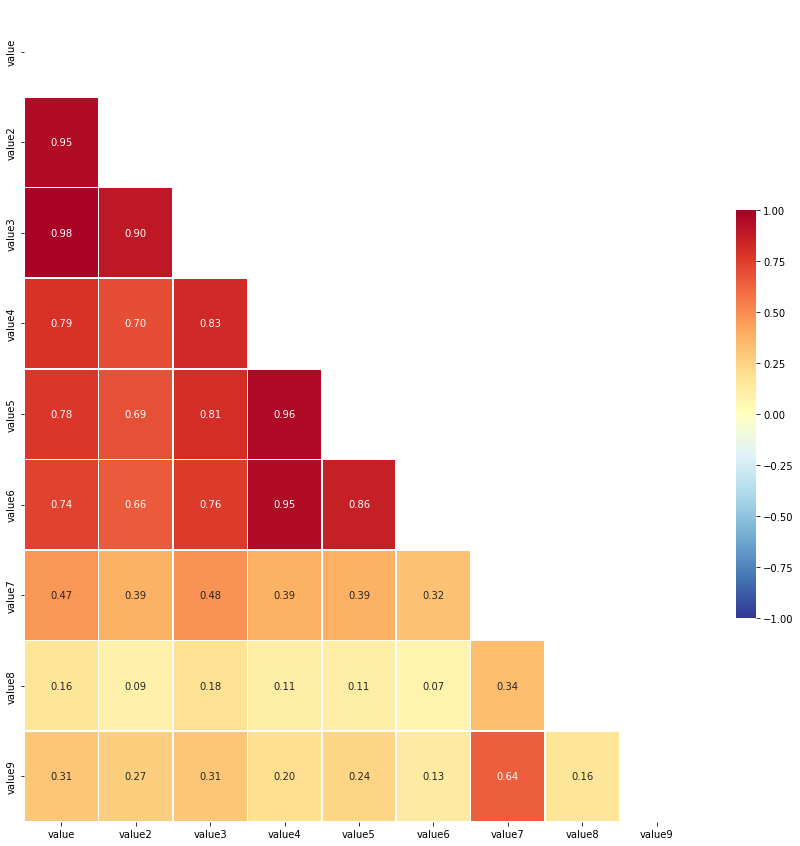

/content/drive/MyDrive/imputation_traindata


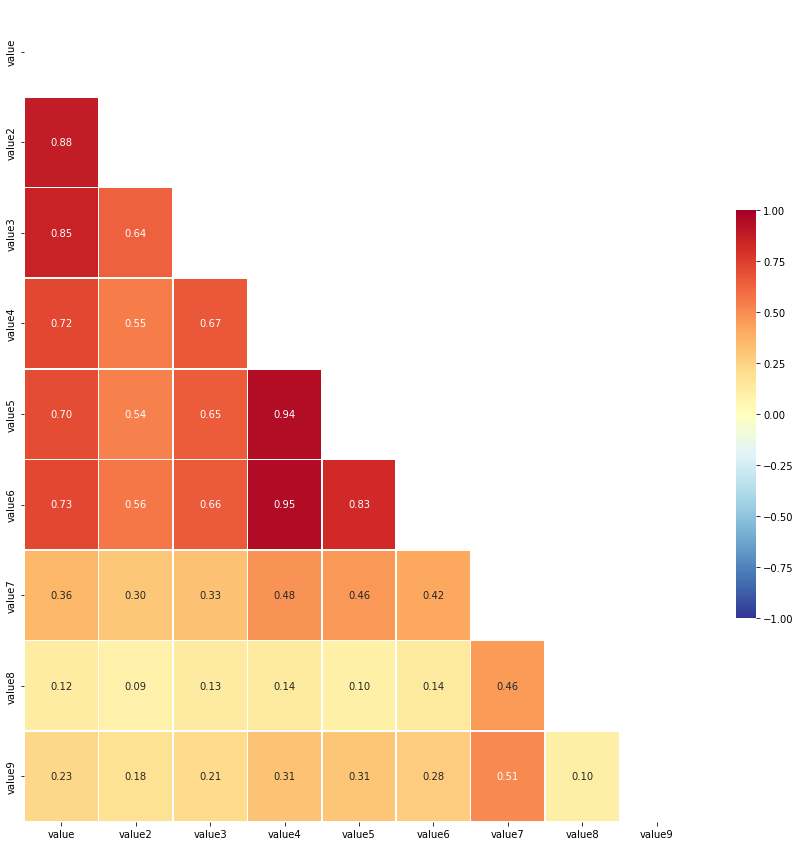

/content/drive/MyDrive/imputation_traindata


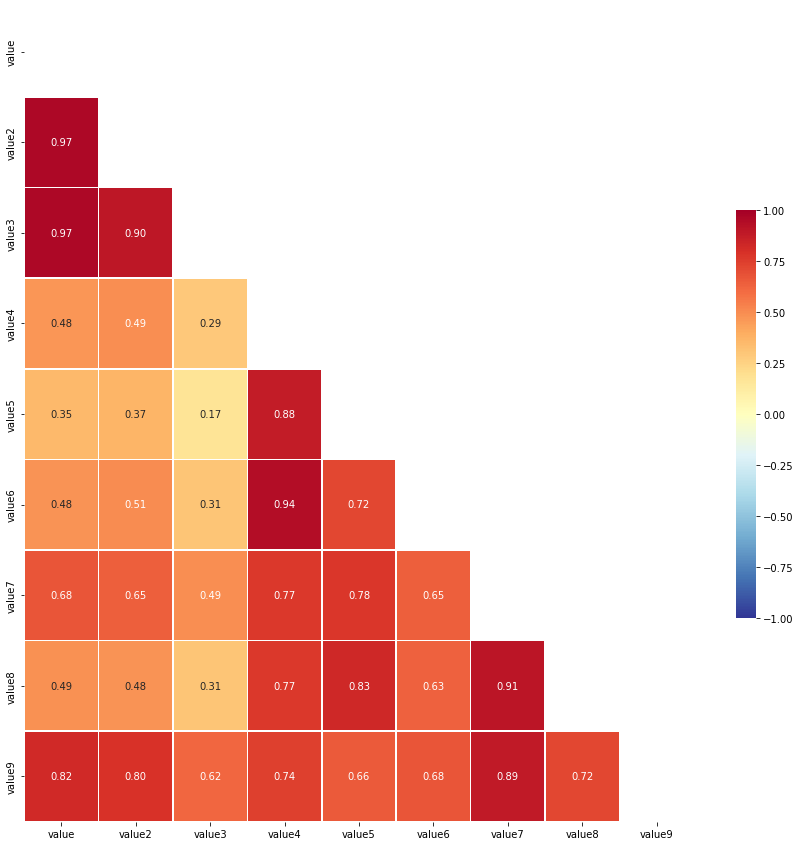

/content/drive/MyDrive/imputation_traindata


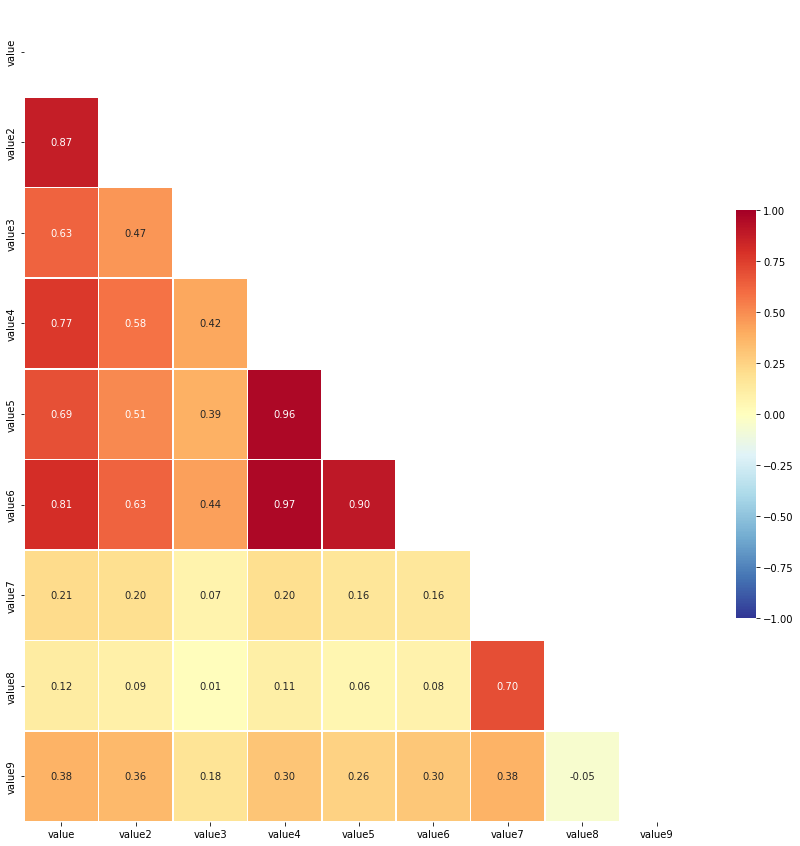

/content/drive/MyDrive/imputation_traindata


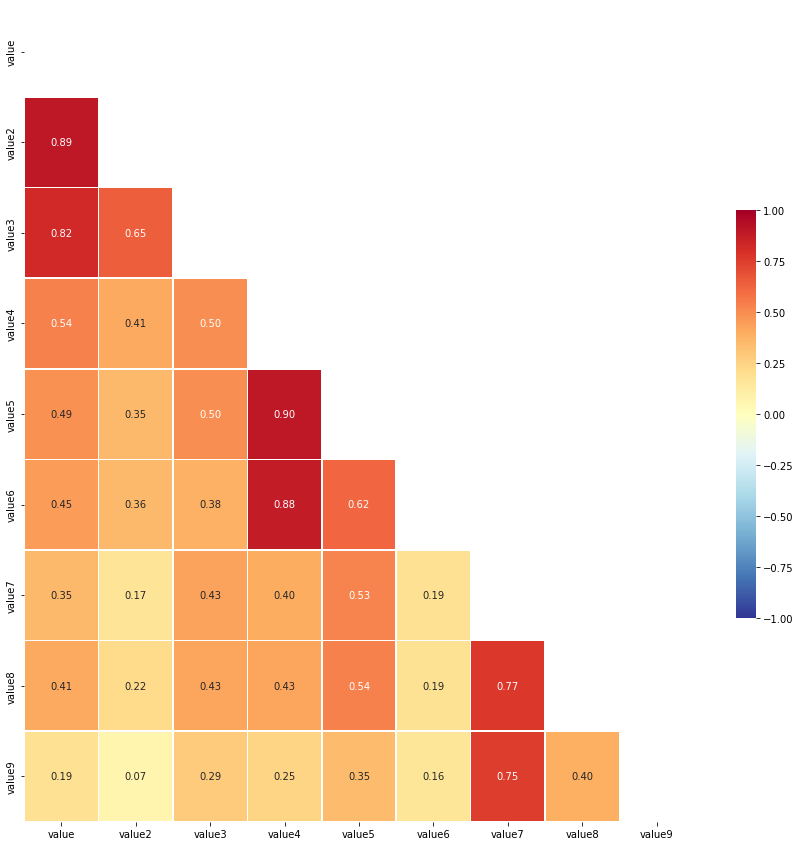

/content/drive/MyDrive/imputation_traindata


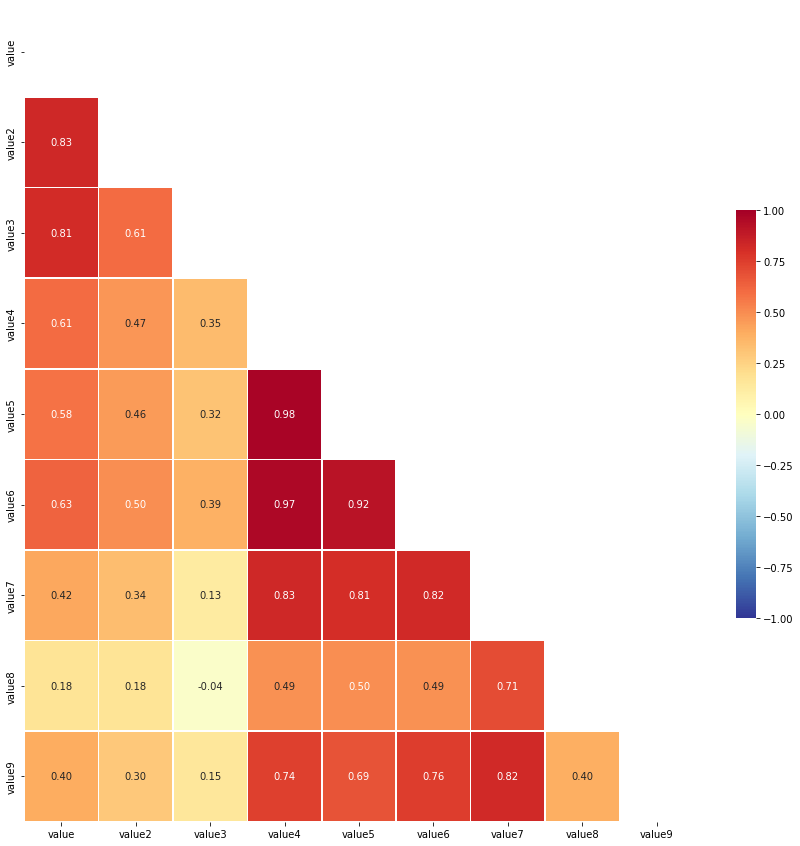

/content/drive/MyDrive/imputation_traindata


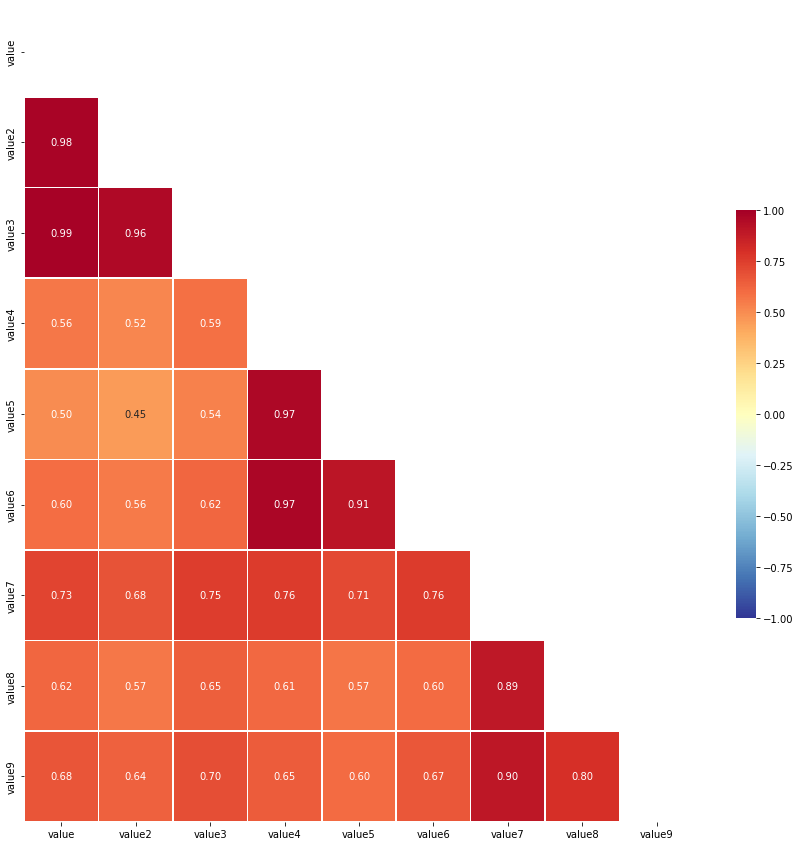

/content/drive/MyDrive/imputation_traindata


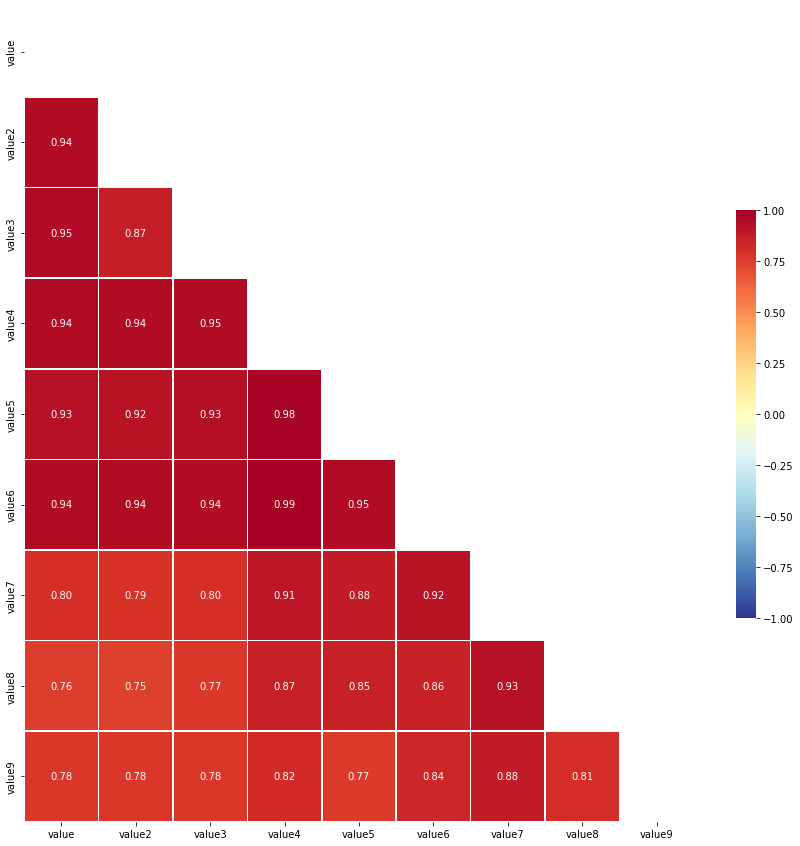

/content/drive/MyDrive/imputation_traindata


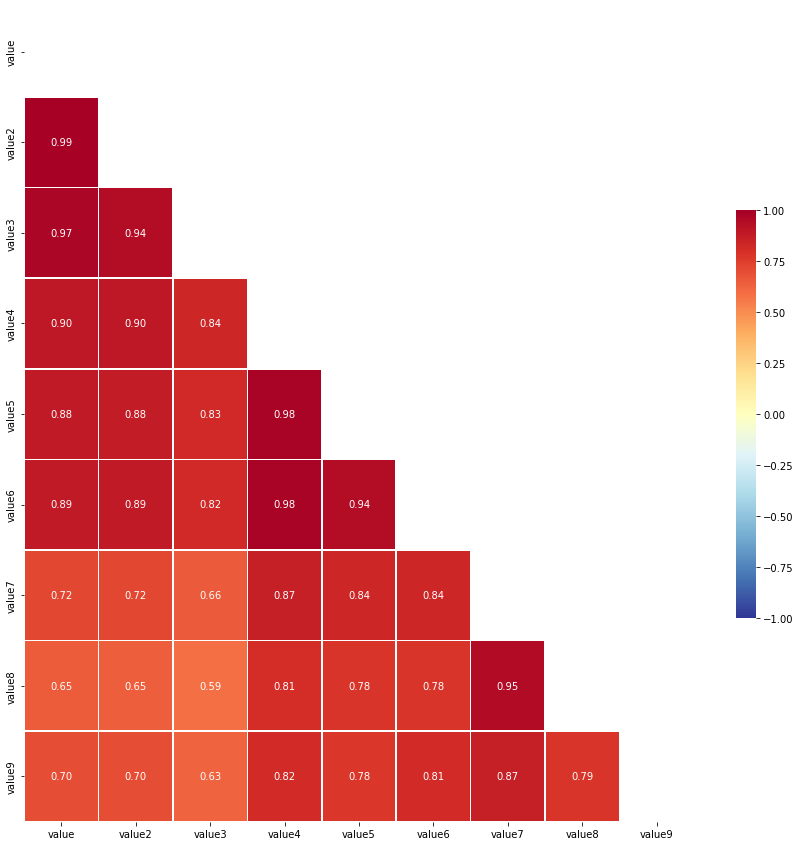

/content/drive/MyDrive/imputation_traindata


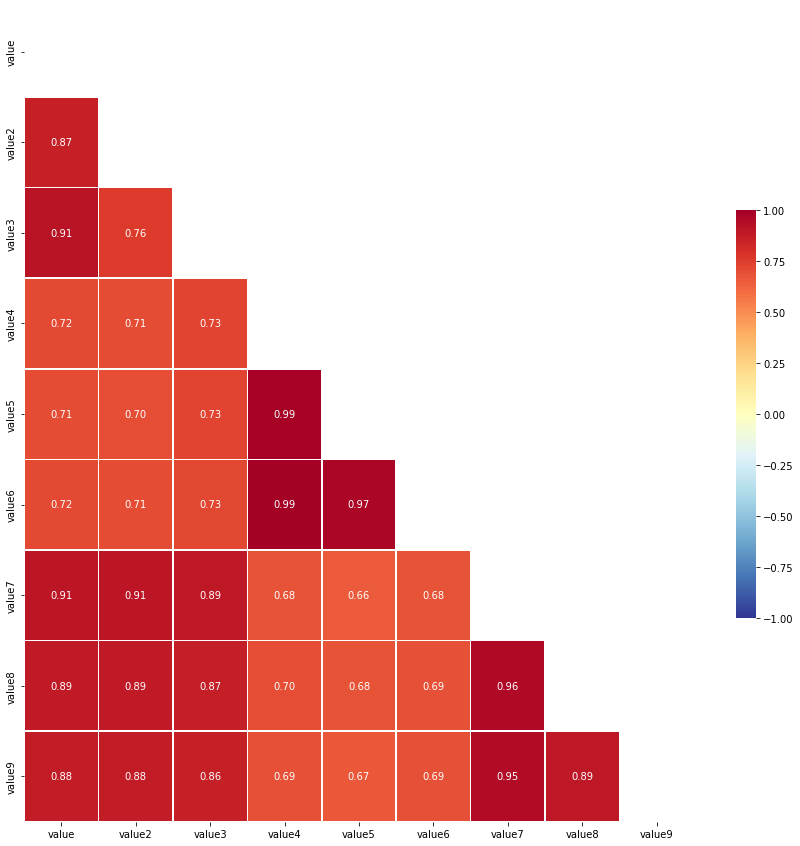

/content/drive/MyDrive/imputation_traindata


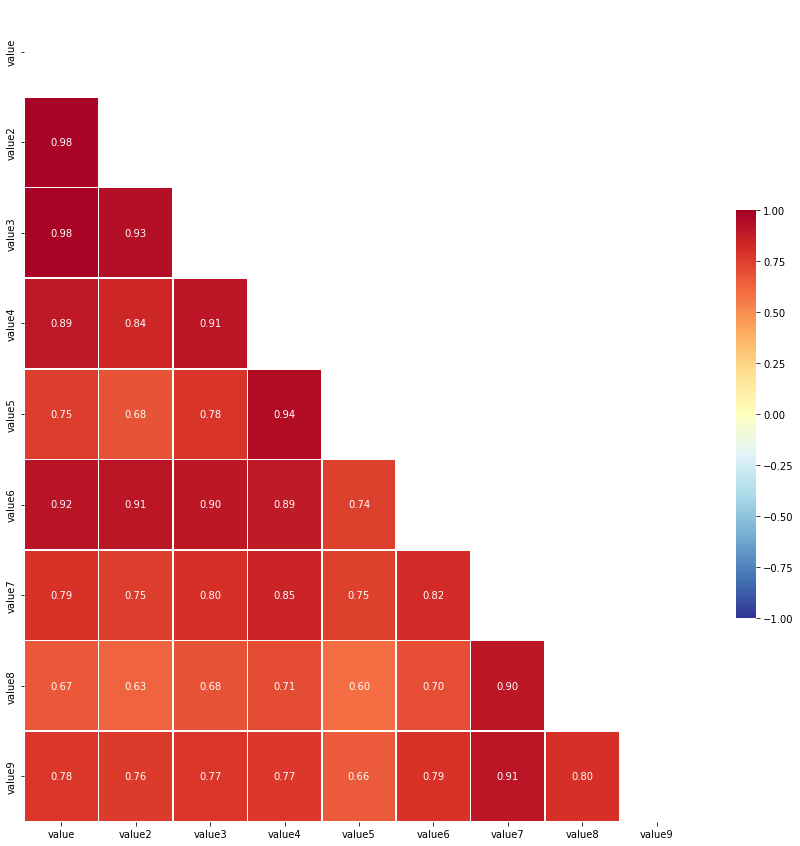

/content/drive/MyDrive/imputation_traindata


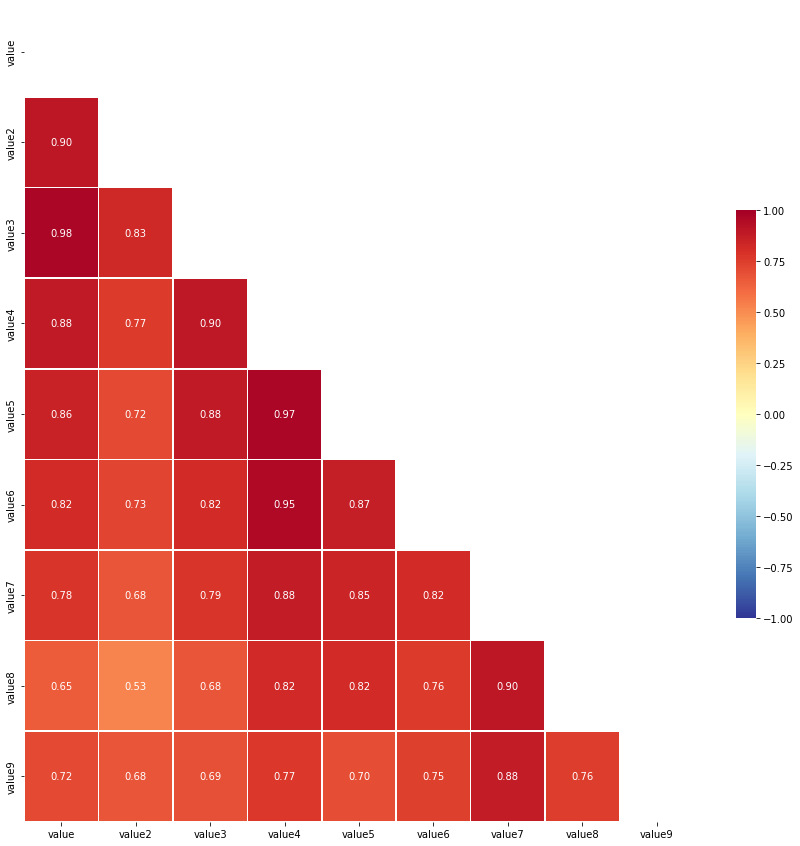

/content/drive/MyDrive/imputation_traindata


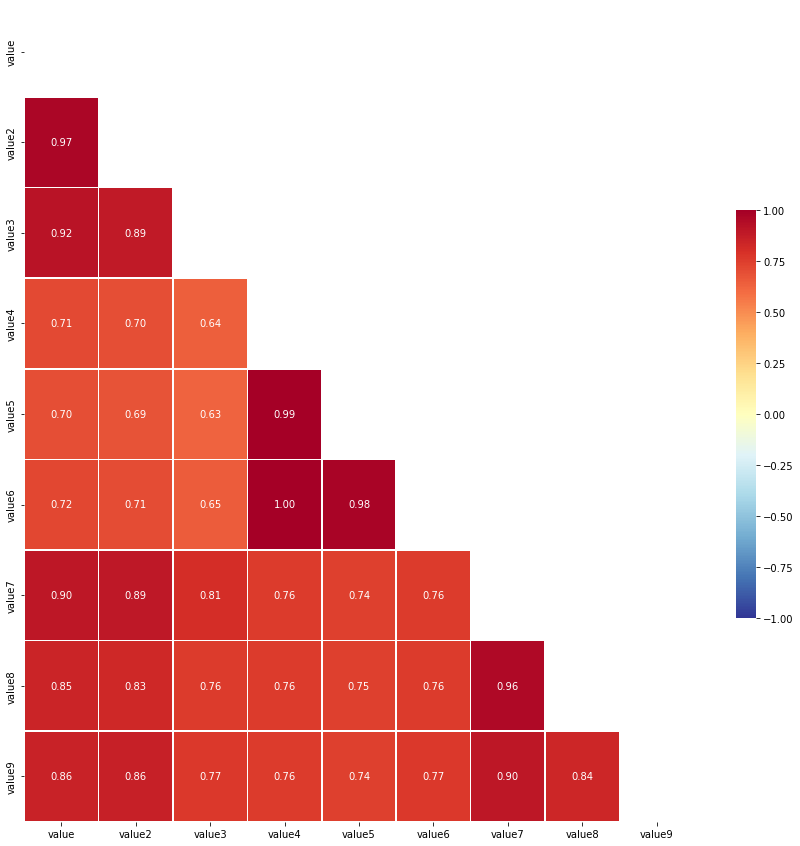

/content/drive/MyDrive/imputation_traindata


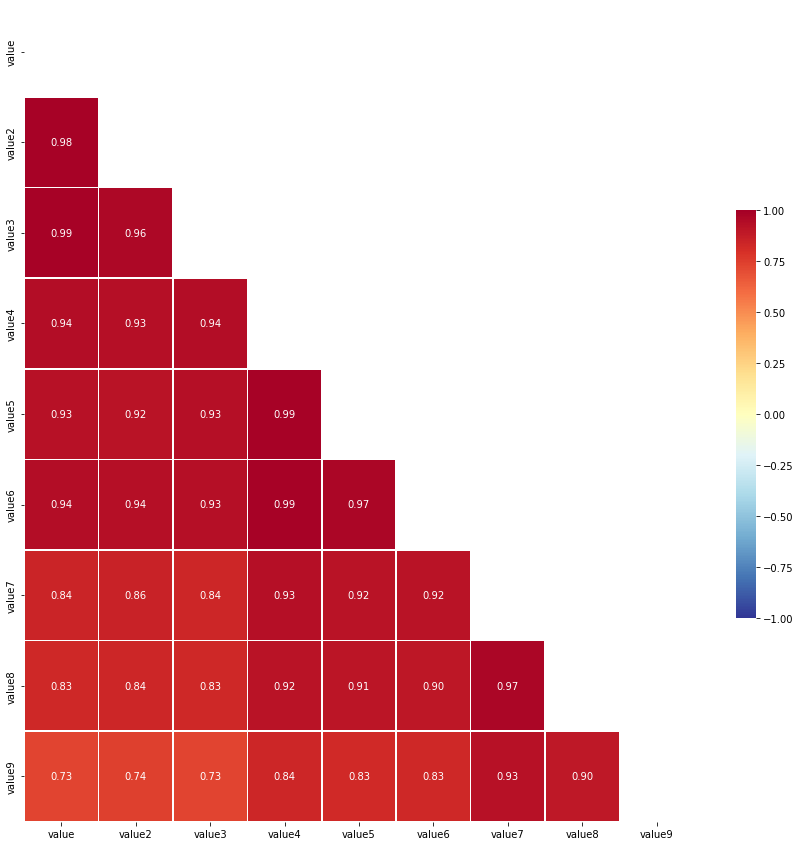

/content/drive/MyDrive/imputation_traindata


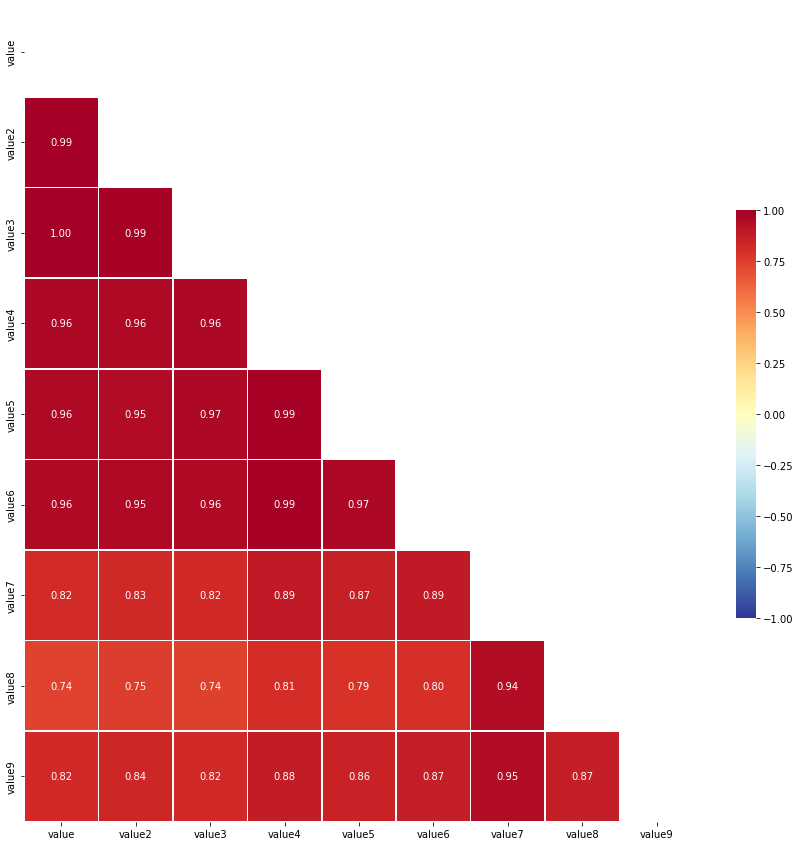

/content/drive/MyDrive/imputation_traindata


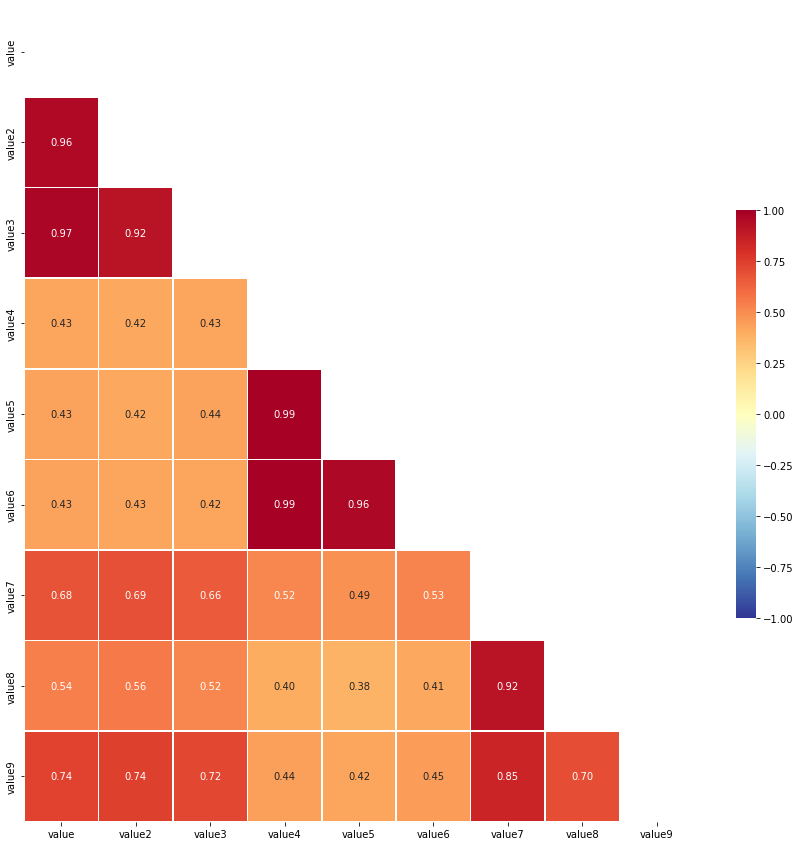

/content/drive/MyDrive/imputation_traindata


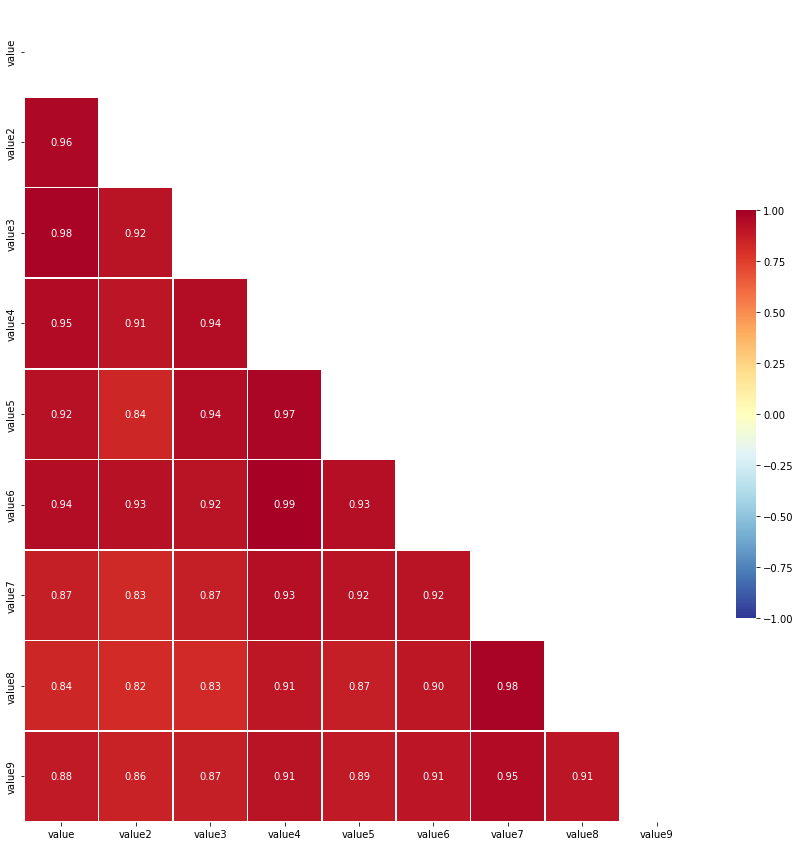

/content/drive/MyDrive/imputation_traindata


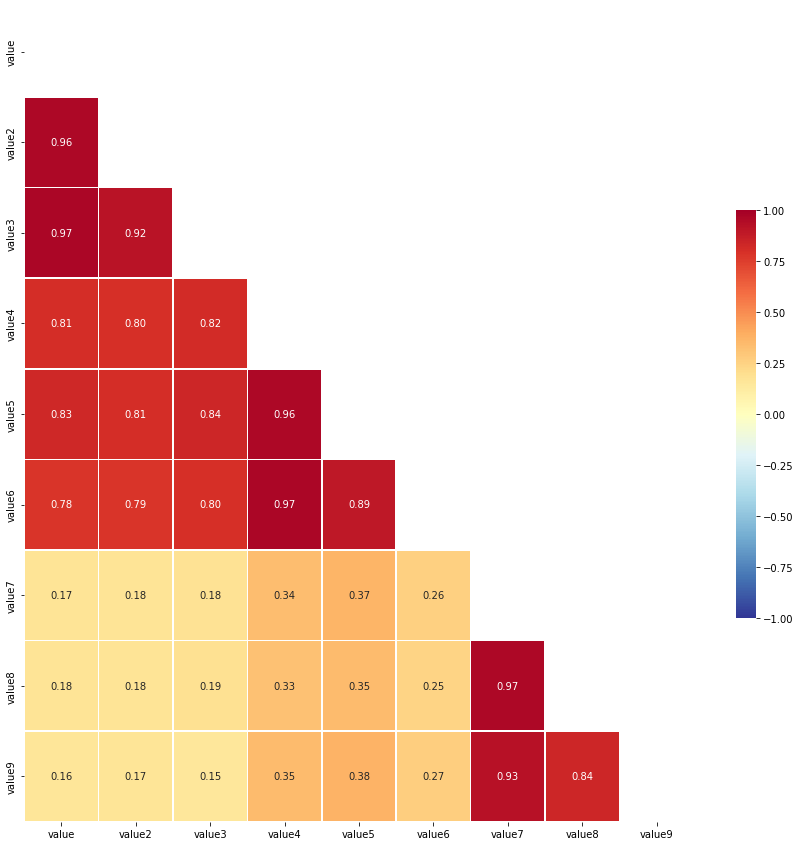

/content/drive/MyDrive/imputation_traindata


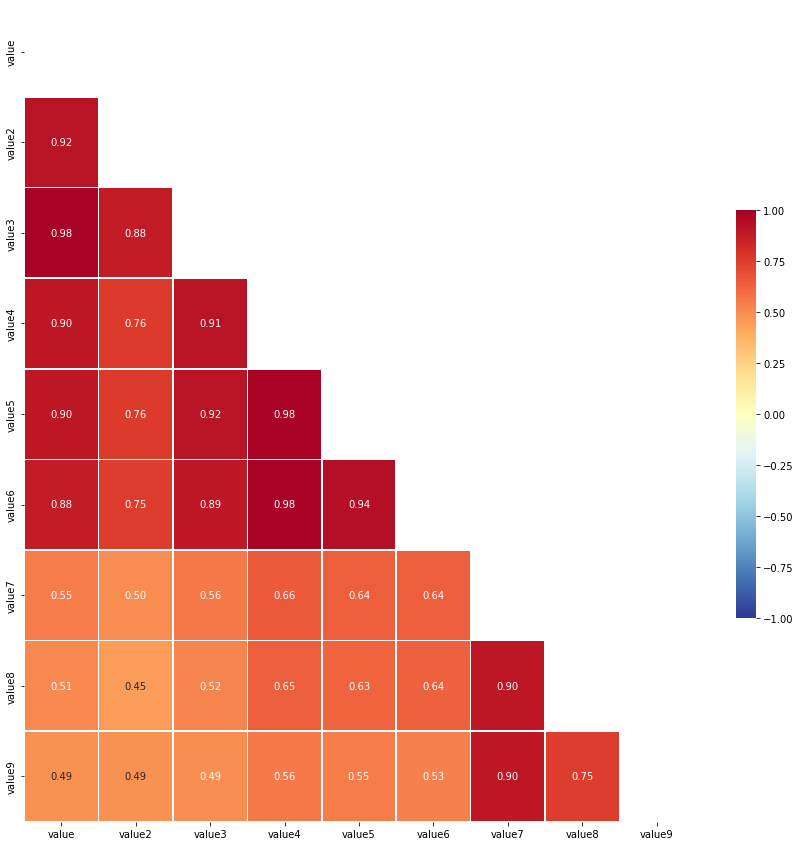

/content/drive/MyDrive/imputation_traindata


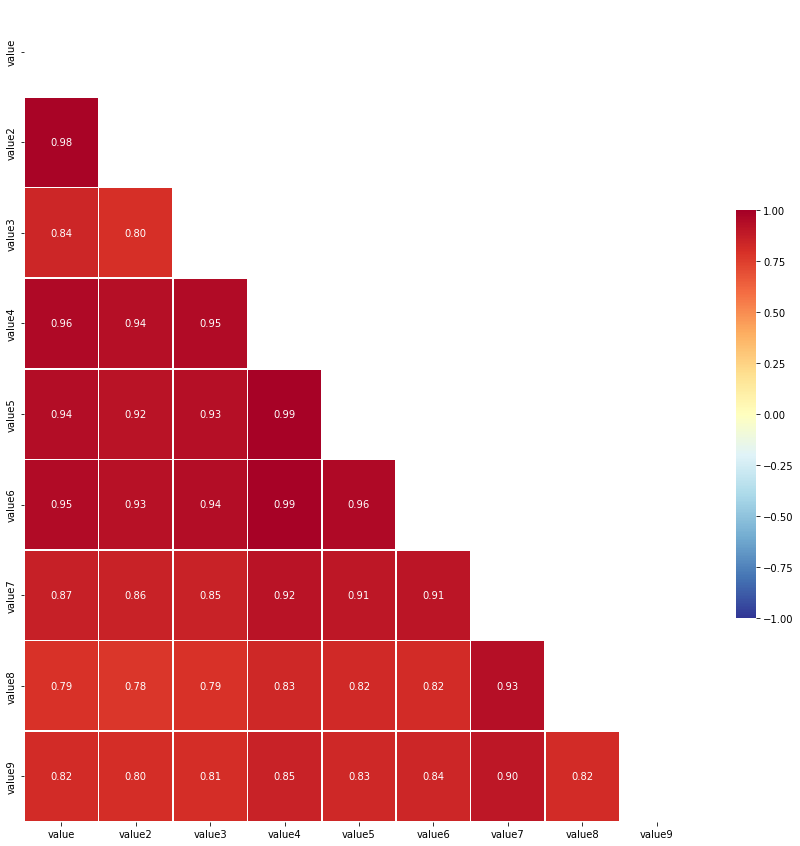

/content/drive/MyDrive/imputation_traindata


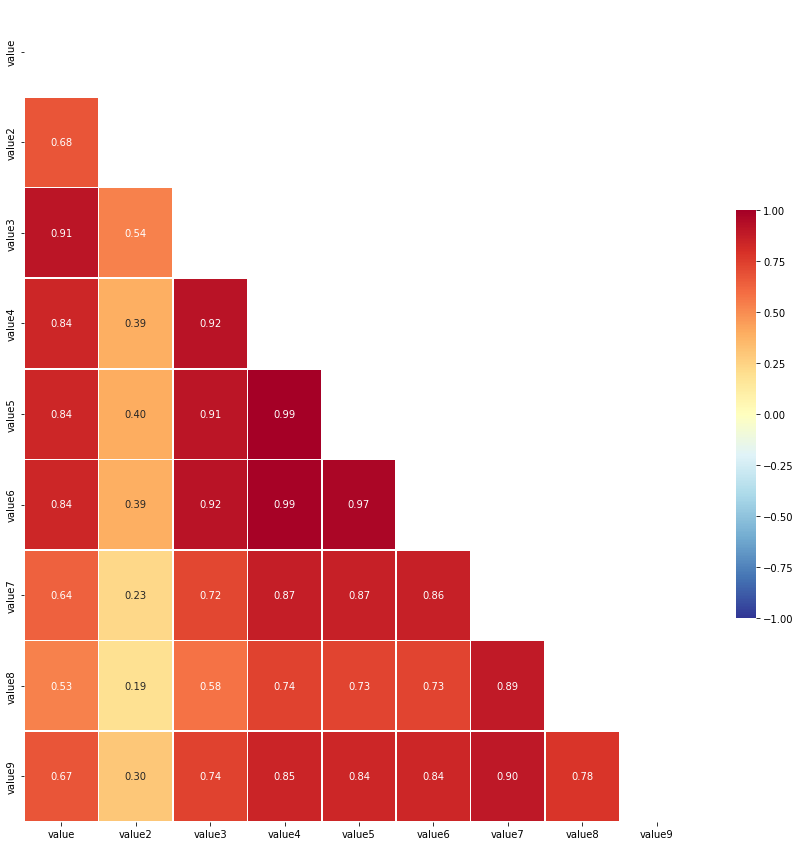

/content/drive/MyDrive/imputation_traindata


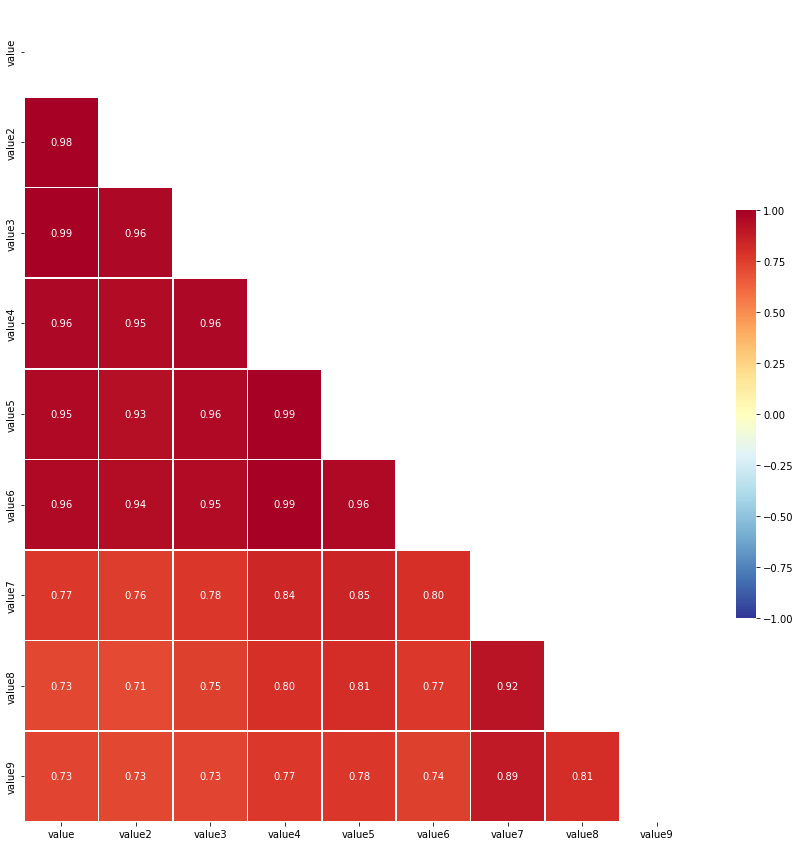

/content/drive/MyDrive/imputation_traindata


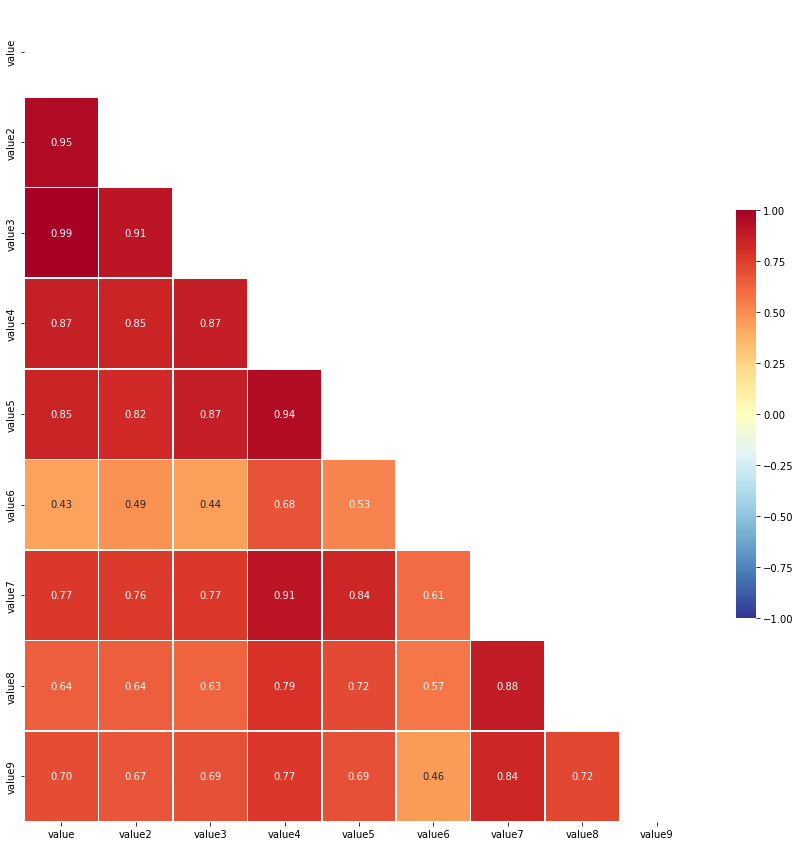

/content/drive/MyDrive/imputation_traindata


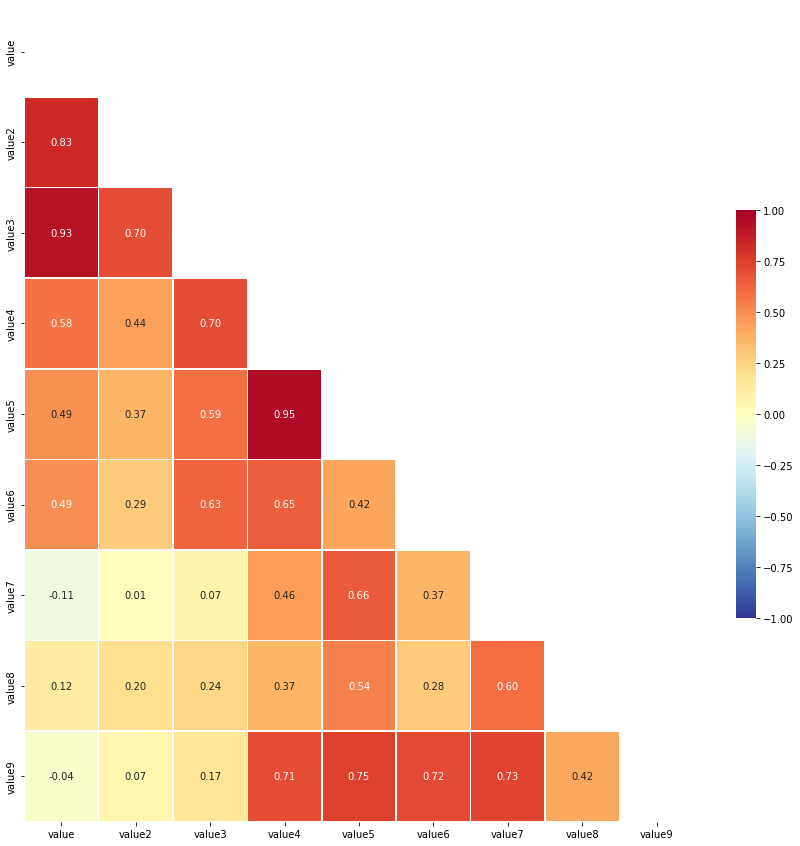

/content/drive/MyDrive/imputation_traindata


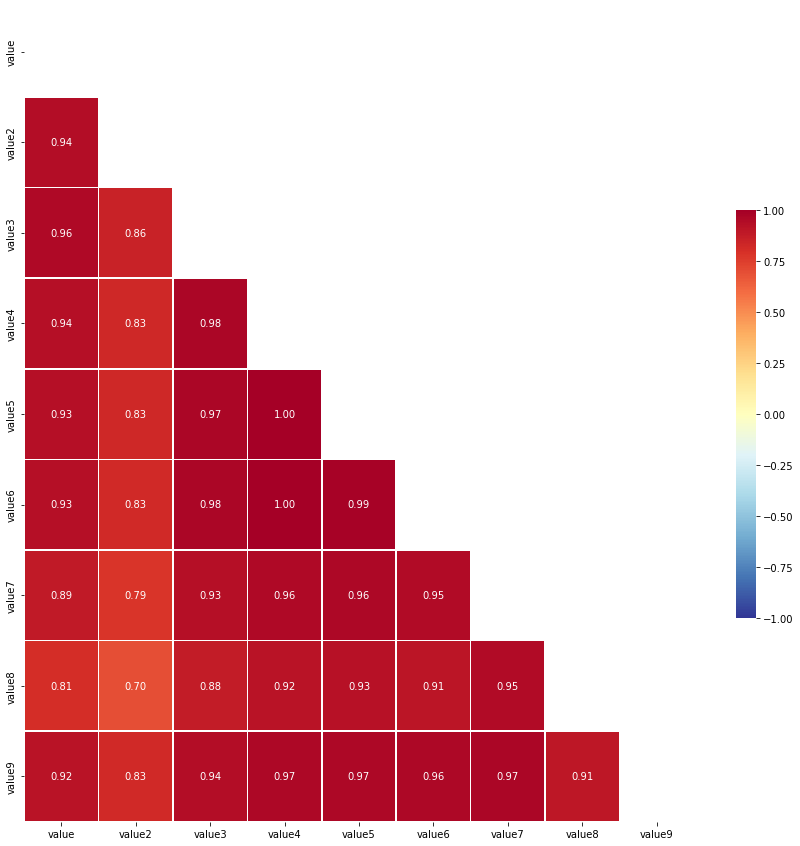

/content/drive/MyDrive/imputation_traindata


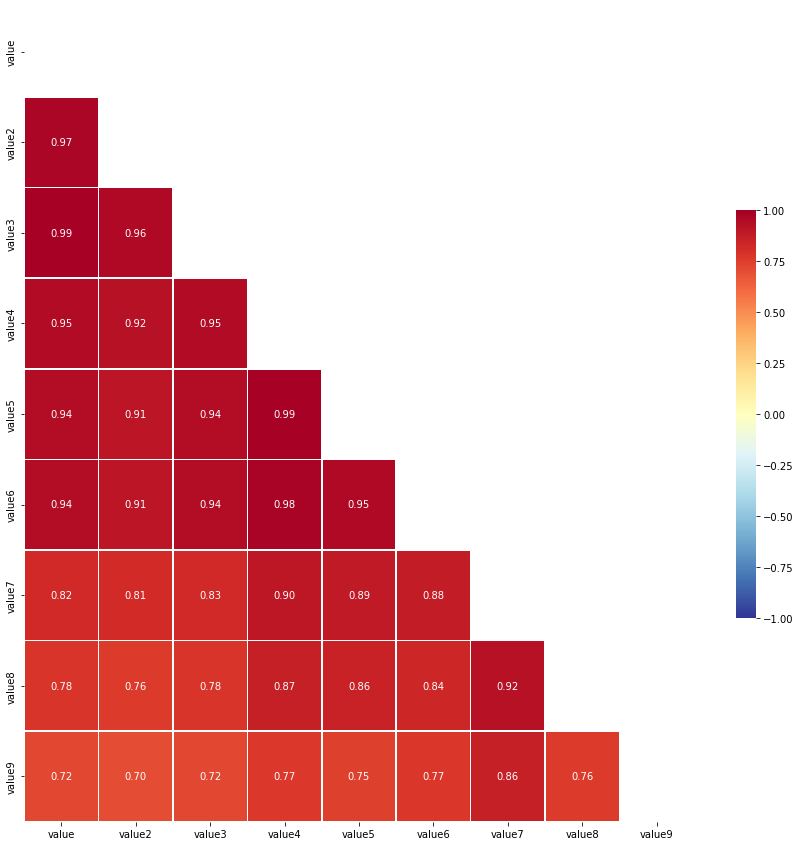

/content/drive/MyDrive/imputation_traindata


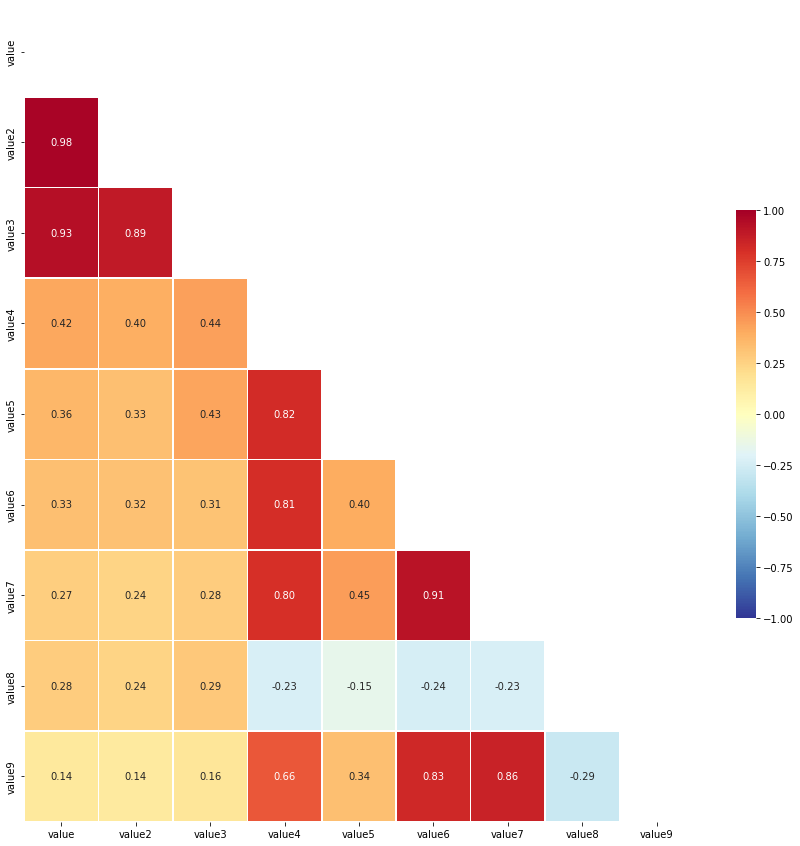

/content/drive/MyDrive/imputation_traindata


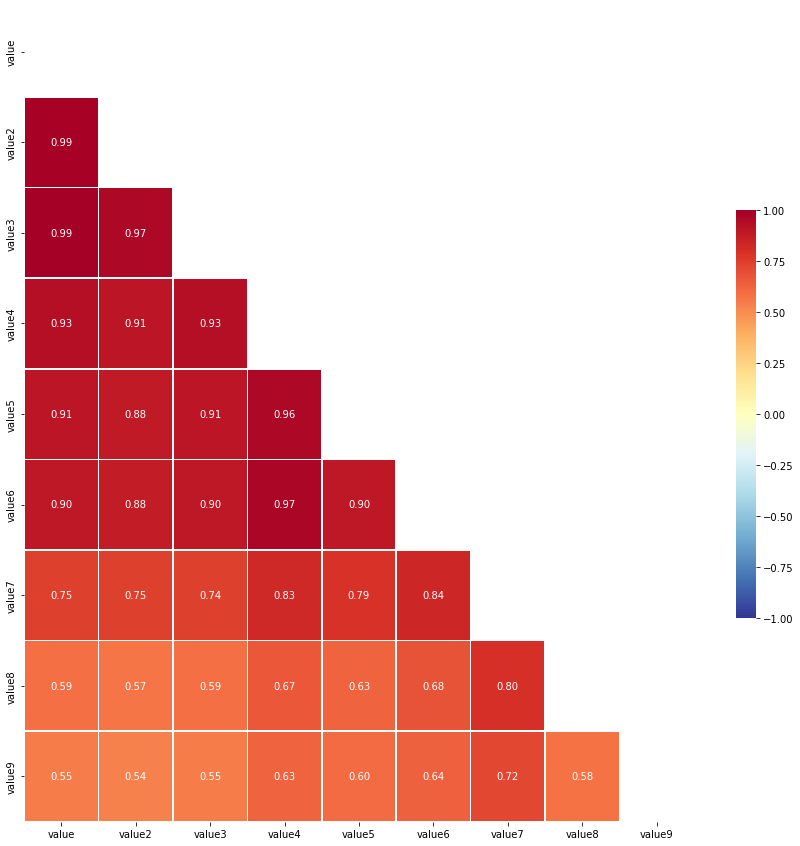

In [ ]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
for j in range(37):
  %cd /content/drive/MyDrive/imputation_traindata/
  new_data = pd.read_csv(f"train_{j}_imputated.csv", encoding='utf-8')
  new_data["value"] = new_data["해당일자_전체평균가격(원)"]
  new_data['value2'] = new_data["하위가격 평균가(원)"]
  new_data["value3"] = new_data["상위가격 평균가(원)"]
  new_data['value4'] = new_data['일자별_도매가격_평균(원)']
  new_data['value5'] = new_data['일자별_도매가격_최대(원)']
  new_data['value6'] = new_data['일자별_도매가격_최소(원)']
  new_data['value7'] = new_data['일자별_소매가격_평균(원)']
  new_data['value8'] = new_data['일자별_소매가격_최대(원)']
  new_data['value9'] = new_data['일자별_소매가격_최소(원)']
  new_data.fillna(method='ffill')
  new_data.fillna(0)
  new_data=new_data[['value','value2','value3','value4','value5','value6','value7','value8','value9']]
  sa = new_data.corr()
  # 그림 사이즈 지정
  fig, ax = plt.subplots( figsize=(15, 15) )

  # 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
  mask = np.zeros_like(sa, dtype=np.bool)
  mask[np.triu_indices_from(mask)] = True

  # 히트맵을 그린다
  sns.heatmap(sa,
              cmap = 'RdYlBu_r',
              annot = True,   # 실제 값을 표시한다
              mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
              fmt = '.2f',
              linewidths=.5,  # 경계면 실선으로 구분하기
              cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
              vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
            )
  plt.show()

이상치 np.nan으로 제거

In [90]:
#이상치 제거
def outlier(data):
  q1,q3=np.percentile(data,[10,90])
  iqr = q3-q1
  lower_bound = q1-(iqr*1.5)
  upper_bound = q3+(iqr*1.5)
  outlier_index = data[ (data<lower_bound) | (data>upper_bound) ].index
  return outlier_index

for j in range(37):
  %cd /content/drive/MyDrive/imputation_traindata/
  new_data = pd.read_csv(f"train_{j}_imputated.csv", encoding='utf-8')
  
  new_data["value1"] = new_data["해당일자_전체평균가격(원)"]
  new_data['value2'] = new_data["하위가격 평균가(원)"]
  new_data["value3"] = new_data["상위가격 평균가(원)"]
  new_data=new_data[['datadate','value1','value2','value3']]
  print(new_data.head())
  for k in range(1,4):
    index_loc=outlier(new_data[f"value{k}"])
    for l in range(len(index_loc)):
      new_data[f"value{k}"][index_loc[l]]=np.nan
  new_data["해당일자_전체평균가격(원)"]=new_data['value1']
  new_data["하위가격 평균가(원)"]=new_data['value2']
  new_data["상위가격 평균가(원)"]=new_data['value3']
  new_data.to_csv(f'train2_{j}_imputated.csv',index=False)
#plt.figure(figsize=(12,8))
#plt.boxplot(pd_check['해당일자_전체평균가격(원)'])
#plt.plot(pd_check['상위가격 거래물량(kg)'])
#plt.show()



#print(df.head())

/content/drive/MyDrive/imputation_traindata
   datadate      value1     value2     value3
0  20130101   3818.2502  2389.7980   7132.353
1  20130102  20705.2200  4604.8430  40025.812
2  20130103   3401.9148  2003.2201   7525.859
3  20130104   6552.6665  2266.2420   8246.376
4  20130105   4298.7637  2882.1940   9703.865
/content/drive/MyDrive/imputation_traindata
   datadate     value1     value2     value3
0  20130101  1273.7605  1086.9040  1575.1504
1  20130102  1260.6967  1159.5725  1509.4565
2  20130103  1284.2710  1025.3949  1586.2665
3  20130104  1294.1644  1084.4438  1622.7903
4  20130105  1278.1176  1009.1654  1652.6569


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/content/drive/MyDrive/imputation_traindata
   datadate     value1     value2     value3
0  20130101  1811.3666  1521.4458  2235.6519
1  20130102  1476.7006  1274.5340  1846.9447
2  20130103  1567.6530  1282.2877  1892.2670
3  20130104  1515.2374  1249.1162  1850.7799
4  20130105  1478.8704  1233.2019  1756.4014
/content/drive/MyDrive/imputation_traindata
   datadate     value1     value2     value3
0  20130101  2137.9077  1645.0314  2692.0220
1  20130102  2013.4147  1578.9863  2632.8218
2  20130103  2131.3567  1627.4817  2672.7117
3  20130104  1885.0625  1578.0034  2277.2375
4  20130105  1900.3594  1577.4037  2336.6380
/content/drive/MyDrive/imputation_traindata
   datadate     value1     value2     value3
0  20130101  1838.6516  1447.5767  2254.4639
1  20130102  1587.5089  1192.8142  2047.3010
2  20130103  1731.9010  1420.4637  2046.8000
3  20130104  1433.6781  1108.4126  1803.1267
4  20130105  1549.7283  1231.4309  1950.4258
/content/drive/MyDrive/imputation_traindata
   datadate   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/content/drive/MyDrive/imputation_traindata
   datadate     value1     value2     value3
0  20130101  3794.4292  3737.4710  1218.9233
1  20130102  3484.0550  3612.9304  2686.9858
2  20130103  3313.7756  3557.6624  3209.4077
3  20130104  3220.5586  3552.0015  3389.0093
4  20130105  3262.6514  3484.3280  3492.3647
/content/drive/MyDrive/imputation_traindata
   datadate     value1     value2     value3
0  20130101  2079.3044  1612.9360  2324.7495
1  20130102  1741.0725  1459.7812  2026.3949
2  20130103  1931.6019  1722.9523  2223.0503
3  20130104  1867.7128  1614.7160  2173.2026
4  20130105  1846.7457  1597.5127  2153.5680
/content/drive/MyDrive/imputation_traindata
   datadate     value1     value2     value3
0  20130101  3300.7463  2377.2837  4884.0860
1  20130102  2588.4500  1305.4965  3841.7957
2  20130103  3300.7917  2433.7808  5114.4790
3  20130104  3316.4650  2424.8262  5709.6270
4  20130105  3204.1675  2428.4294  5565.7730


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/content/drive/MyDrive/imputation_traindata
   datadate     value1     value2     value3
0  20130101  1511.3473  1310.5157  1687.1017
1  20130102  1440.2487  1207.9885  1625.0072
2  20130103  1465.5933  1302.7119  1603.4304
3  20130104  1396.7457  1211.4956  1562.9978
4  20130105  1380.9850  1101.7308  1559.6671
/content/drive/MyDrive/imputation_traindata
   datadate     value1     value2     value3
0  20130101  1669.9092  1414.4271  1908.0604
1  20130102  1610.3687  1352.6987  2079.5620
2  20130103  1667.1440  1471.4308  1832.0883
3  20130104  1801.6091  1242.5756  1998.5510
4  20130105  1819.0978  1698.2944  2037.5822
/content/drive/MyDrive/imputation_traindata
   datadate     value1     value2     value3
0  20130101  2772.9355  2319.9597  3321.8530
1  20130102  1750.2357  1624.5889  2062.4224
2  20130103  1831.3218  1611.7720  2175.3093
3  20130104  1738.4459  1536.4102  2055.1873
4  20130105  1762.2274  1583.8827  2174.6255
/content/drive/MyDrive/imputation_traindata
   datadate   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/content/drive/MyDrive/imputation_traindata
   datadate     value1     value2     value3
0  20130101  2743.3398  2308.4216  3098.9390
1  20130102  2834.8245  2422.4812  3142.6287
2  20130103  3068.9788  2417.1501  3515.4546
3  20130104  2789.5203  2268.6978  3486.1438
4  20130105  3045.3420  2213.3552  3297.4363
/content/drive/MyDrive/imputation_traindata
   datadate     value1     value2     value3
0  20130101   8194.489  6677.7925  10525.586
1  20130102   6947.619  6284.1750   9312.280
2  20130103  10054.998  8431.8430  11178.813
3  20130104   9689.347  8685.6680  10895.462
4  20130105   8294.165  7100.3360   9382.187
/content/drive/MyDrive/imputation_traindata
   datadate     value1     value2     value3
0  20130101  1743.9772  1393.2856  2315.9783
1  20130102  1806.5221  1363.2698  2918.8103
2  20130103  1553.2377  1253.3750  1779.6547
3  20130104  1360.5382  1094.8087  1669.3638
4  20130105  1303.8622  1078.0792  1582.7092
/content/drive/MyDrive/imputation_traindata
   datadate   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


   datadate     value1     value2     value3
0  20130101  1653.9331  1121.2465  2125.1355
1  20130102  1789.3707  1239.0597  2399.6143
2  20130103  1896.2909  1412.1871  2363.9736
3  20130104  1893.4984  1396.2701  2474.1995
4  20130105  1880.2057  1284.1764  2551.2605
/content/drive/MyDrive/imputation_traindata
   datadate     value1     value2      value3
0  20130101  694.78500  514.30070  1073.47000
1  20130102  731.83360  475.93942  1109.01180
2  20130103  864.49854  741.73160  1372.76420
3  20130104  822.97064  653.08700   994.23456
4  20130105  790.98400  654.60160   984.70670
/content/drive/MyDrive/imputation_traindata
   datadate    value1     value2      value3
0  20130101  713.4616  517.55990   981.77550
1  20130102  814.5094  561.72864  1195.41190
2  20130103  942.4175  707.38480  1170.10100
3  20130104  902.3974  672.38947  1094.92140
4  20130105  873.7880  665.96110  1016.93054
/content/drive/MyDrive/imputation_traindata
   datadate     value1     value2     value3
0  2013

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/content/drive/MyDrive/imputation_traindata
   datadate      value1     value2     value3
0  20130101  1094.92130  839.66630  1491.4272
1  20130102  1243.85120  964.85596  1923.6582
2  20130103   858.84015  616.92065  1172.2983
3  20130104   797.33260  562.58264  1146.3177
4  20130105   825.36770  619.04803  1210.3347
/content/drive/MyDrive/imputation_traindata
   datadate     value1     value2     value3
0  20130101  2619.7070  1920.0753  3613.0600
1  20130102  2660.5828  1981.2068  3738.9736
2  20130103  2297.9644  1583.2060  3138.4219
3  20130104  2225.4773  1609.6285  2978.9841
4  20130105  2049.0566  1493.2688  2720.0630
/content/drive/MyDrive/imputation_traindata
   datadate     value1     value2     value3
0  20130101  2323.0813  1705.7139  3295.1380
1  20130102  2114.6130  1595.7412  3140.3142
2  20130103  3668.4548  2453.9040  5868.2007
3  20130104  3935.2410  2655.6520  5756.6577
4  20130105  3177.5671  2239.5480  4743.6265
/content/drive/MyDrive/imputation_traindata
   datad

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


   datadate      value1     value2      value3
0  20130101   676.13275  593.12805   789.95856
1  20130102   854.97060  741.02270  1009.37270
2  20130103  1079.48770  880.35443  1190.78370
3  20130104  1145.27010  975.03735  1304.96370
4  20130105  1082.54520  913.11884  1188.50710
/content/drive/MyDrive/imputation_traindata
   datadate     value1     value2     value3
0  20130101  1337.2928  852.63740  1905.2335
1  20130102  1513.2850  923.98535  2244.1877
2  20130103  1748.4226  984.83575  2654.8025
3  20130104  1640.4641  985.77880  2518.0156
4  20130105  1812.0889  922.72960  2651.6033
/content/drive/MyDrive/imputation_traindata
   datadate     value1     value2      value3
0  20130101  809.30700  683.41730   908.68530
1  20130102  885.33887  709.95110   983.46050
2  20130103  898.44763  661.82306  1009.70166
3  20130104  970.35986  843.56540  1070.15550
4  20130105  972.93475  800.26416  1095.26700
/content/drive/MyDrive/imputation_traindata
   datadate     value1     value2     va

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/content/drive/MyDrive/imputation_traindata
   datadate     value1     value2     value3
0  20130101  4654.7420  3079.4204  5693.7593
1  20130102  6414.3286  4919.1377  6877.5680
2  20130103  5965.7256  4614.5933  6773.5835
3  20130104  5446.7940  3578.0222  6565.9810
4  20130105  4379.5200  4142.1074  6291.7544
/content/drive/MyDrive/imputation_traindata
   datadate     value1     value2     value3
0  20130101  3626.1096  2790.8726  4383.0093
1  20130102  1838.1809  1502.6538  2297.3616
2  20130103  1773.3833  1170.2146  2581.3982
3  20130104  1768.3528  1168.0823  2311.8470
4  20130105  1661.6301  1082.8545  2096.1400
/content/drive/MyDrive/imputation_traindata
   datadate     value1     value2     value3
0  20130101  3455.5020  2644.2925  4150.9170
1  20130102  3636.6511  2595.0830  4391.0940
2  20130103  3727.2288  2247.5093  4401.6150
3  20130104  4304.2580  3153.7239  4985.3030
4  20130105  4931.8530  3711.0857  5815.3135
/content/drive/MyDrive/imputation_traindata
   datadate   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/content/drive/MyDrive
    datadate  해당일자_전체평균가격(원)
0   20170101             NaN
1   20170102     4813.021304
2   20170103             NaN
3   20170104     7805.386491
4   20170105     7172.634267
5   20170106     8743.202372
6   20170107     8986.558767
7   20170108     8475.603665
8   20170109     8749.585893
9   20170110             NaN
10  20170111     7516.395688
11  20170112     7837.531171
12  20170113     7750.373690
13  20170114     9253.947514


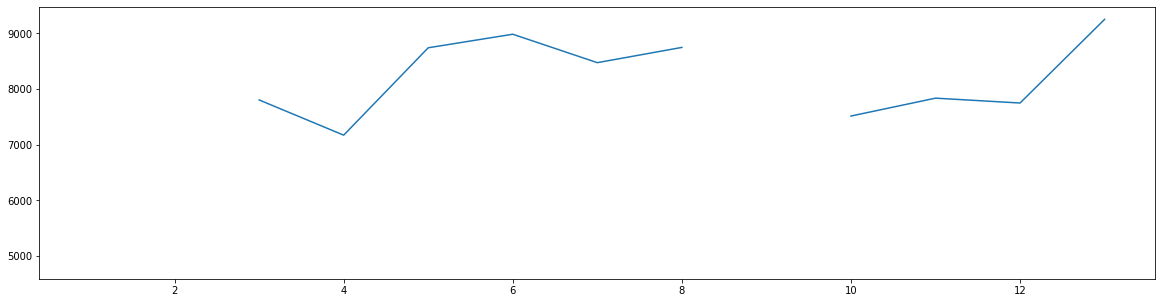

In [ ]:
%cd /content/drive/MyDrive/
#model = Brits_i(108, 1, 0, length, device).to(device)
#model.load_state_dict(torch.load('./imputation_traindata/train1_changed.pt'))
#model.eval() #모델 불러오기,전처리

pd_test = pd.read_csv('./data/test/set_0/test_5.csv')
pd_test = pd_test[['datadate','해당일자_전체평균가격(원)']]
plt.figure(figsize=(20,5))
plt.plot(pd_test['해당일자_전체평균가격(원)'], label="real", zorder=10)
print(pd_test)

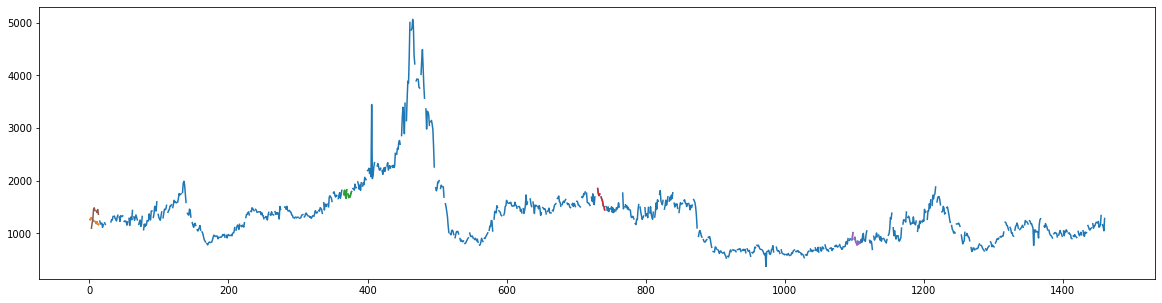

In [ ]:
pd_train = pd.read_csv('./data/train/train_1.csv')
pd_train = pd_train[['datadate','해당일자_전체평균가격(원)']]
plt.figure(figsize=(20,5))
plt.plot(pd_train['해당일자_전체평균가격(원)'])
plt.plot(pd_train['해당일자_전체평균가격(원)'][0:14], label="2013", zorder=10)
plt.plot(pd_train['해당일자_전체평균가격(원)'][0+365:14+365], label="2014", zorder=10)
plt.plot(pd_train['해당일자_전체평균가격(원)'][0+365*2:14+365*2], label="2015", zorder=10)
plt.plot(pd_train['해당일자_전체평균가격(원)'][0+365*3:14+365*3], label="2016", zorder=10)
plt.plot(pd_test['해당일자_전체평균가격(원)'], label="2017", zorder=10)